<h2>Setup</h2>

In [1]:
#%pip install --user gradio
#%pip install --user shap
#%pip install --user lightgbm

<h3> Imports </h3>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from typing import Dict, Any, Optional, List, Literal, Union, Tuple, Set
from scipy.stats import chi2_contingency
from typing import Optional, Tuple, Dict, Any, List, Set
# ML
import gradio as gr 
import shap
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split,  cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config


In [3]:
set_config(transform_output="pandas")

In [4]:
path_data = 'F:\Datasets\LengthOfStay.csv'

df_entry = pd.read_csv(path_data)

In [5]:
df_entry.head(5)

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


In [6]:
df_entry.describe()

,eid,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,fibrosisandother,...,neutrophils,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,lengthofstay
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,50000.500000,0.036420,0.035270,0.094940,0.039450,0.063060,0.239040,0.051660,0.049390,0.004790,...,10.177455,137.891397,141.963384,14.097185,1.099350,29.805759,73.444720,6.493768,2.123310,4.00103
std,28867.657797,0.187334,0.184462,0.293134,0.194664,0.243072,0.426499,0.221341,0.216682,0.069044,...,5.353131,2.999669,29.992996,12.952454,0.200262,2.003769,11.644555,0.568473,2.050641,2.36031
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.100000,124.912632,-1.005927,1.000000,0.219770,21.992683,21.000000,0.200000,0.000000,1.00000
25%,25000.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.700000,135.871062,121.682383,11.000000,0.964720,28.454235,66.000000,6.500000,1.000000,2.00000
50%,50000.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.400000,137.887151,142.088545,12.000000,1.098764,29.807516,73.000000,6.500000,1.000000,4.00000
75%,75000.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.500000,139.912885,162.180996,14.000000,1.234867,31.156885,81.000000,6.500000,3.000000,6.00000
max,100000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,245.900000,151.387283,271.444277,682.500000,2.035202,38.935293,130.000000,10.000000,10.000000,17.00000


In [7]:
df_entry.describe(include='object')

,vdate,rcount,gender,discharged,facid
count,100000,100000,100000,100000,100000
unique,367,6,2,378,5
top,10/3/2012,0,F,2/16/2012,E
freq,333,55031,57643,316,30755


In [8]:
df_entry['vdate'] = pd.to_datetime(df_entry['vdate'])
df_entry['discharged'] = pd.to_datetime(df_entry['discharged'])

In [9]:
df_entry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   eid                         100000 non-null  int64         
 1   vdate                       100000 non-null  datetime64[ns]
 2   rcount                      100000 non-null  object        
 3   gender                      100000 non-null  object        
 4   dialysisrenalendstage       100000 non-null  int64         
 5   asthma                      100000 non-null  int64         
 6   irondef                     100000 non-null  int64         
 7   pneum                       100000 non-null  int64         
 8   substancedependence         100000 non-null  int64         
 9   psychologicaldisordermajor  100000 non-null  int64         
 10  depress                     100000 non-null  int64         
 11  psychother                  100000 non-n

<h3> Coerce types </h3>

In [10]:
def coerce_types(
    df: pd.DataFrame,
    *,
    detect_binary_numeric: bool = True,
    detect_boolean_strings: bool = True,
    true_set: Optional[Set[str]] = None,
    false_set: Optional[Set[str]] = None,
    cast_binary_to: str = "boolean",
    detect_datetime: bool = True,
    datetime_min_ratio: float = 0.8,
    dayfirst: bool = False,
    to_category: bool = True,
    category_max_unique: int = 50,
    category_max_ratio: float = 0.2,
    exclude: Optional[Set[str]] = None,
    inplace: bool = False,
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, Any]]]:
    """
    Coerce column dtypes for EDA: booleans, datetimes, categories.

    Main rules:
      - Binary numeric {0,1} -> boolean/category.
      - Boolean-like strings (e.g. "yes"/"no") -> boolean.
      - Object with date-like strings -> datetime64[ns] if ``datetime_min_ratio`` reached.
      - Object with low cardinality -> category.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    detect_binary_numeric : bool, optional
        Convert numeric columns with values in {0,1} to boolean/category. Default True.
    detect_boolean_strings : bool, optional
        Convert object columns with boolean-like strings to boolean. Default True.
    true_set : set of str, optional
        Labels considered True (case-insensitive). Default: {"1","true","t","y","yes","sim","s"}.
    false_set : set of str, optional
        Labels considered False (case-insensitive). Default: {"0","false","f","n","no","nao","não"}.
    cast_binary_to : {"boolean","category"}, optional
        Destination dtype for binary columns. Default "boolean".
    detect_datetime : bool, optional
        Detect and convert object columns to datetime64[ns]. Default True.
    datetime_min_ratio : float, optional
        Minimum fraction of valid parses to accept datetime. Default 0.8.
    dayfirst : bool, optional
        Parse dates with dayfirst=True. Default False.
    to_category : bool, optional
        Convert object columns with low cardinality to category. Default True.
    category_max_unique : int, optional
        Absolute max unique values for conversion to category. Default 50.
    category_max_ratio : float, optional
        Relative max unique ratio (unique/n) for conversion to category. Default 0.2.
    exclude : set of str, optional
        Columns to skip from conversion.

    Returns
    -------
    (df_out, report) : (pandas.DataFrame, dict)
        ``df_out`` with adjusted dtypes and ``report`` with changes by column:
        {"col": {"from": old_dtype, "to": new_dtype, "reason": reason}}.
    """
    df_out = df if inplace else df.copy()
    report: Dict[str, Dict[str, Any]] = {}
    excl = exclude or set()

    tset = { "1","true","t","y","yes","sim","s" } if true_set is None else {x.lower().strip() for x in true_set}
    fset = { "0","false","f","n","no","nao","não" } if false_set is None else {x.lower().strip() for x in false_set}

    for col in df_out.columns:
        if col in excl:
            continue
        s = df_out[col]
        before = str(s.dtype)
        reason = None


        if detect_binary_numeric and pd.api.types.is_numeric_dtype(s):
            uniq = pd.unique(s.dropna())
            if len(uniq) <= 2 and set(np.unique(uniq)).issubset({0, 1}):
                if cast_binary_to == "boolean":
                    df_out[col] = s.astype("boolean")
                    reason = "binary_numeric->boolean"
                else:
                    df_out[col] = s.astype("category")
                    reason = "binary_numeric->category"

  
        if reason is None and detect_boolean_strings and pd.api.types.is_object_dtype(s):
            vals = s.dropna().astype(str).str.strip().str.lower().unique()
            if len(vals) > 0 and set(vals).issubset(tset.union(fset)):
                mapped = s.astype("string").str.strip().str.lower().map(
                    {**{v: True for v in tset}, **{v: False for v in fset}}
                )
                df_out[col] = mapped.astype("boolean")
                reason = "string_boolean->boolean"


        if reason is None and detect_datetime and pd.api.types.is_object_dtype(df_out[col]):
            parsed = pd.to_datetime(df_out[col], errors="coerce", dayfirst=dayfirst)
            ratio = parsed.notna().mean() if len(parsed) else 0.0
            if ratio >= float(datetime_min_ratio):
                df_out[col] = parsed
                reason = f"object->datetime (ratio={ratio:.2f})"


        if reason is None and to_category and pd.api.types.is_object_dtype(df_out[col]):
            s2 = df_out[col]
            n = len(s2)
            nunq = s2.nunique(dropna=True)
            if (nunq <= category_max_unique) or (n > 0 and (nunq / n) <= category_max_ratio):
                df_out[col] = s2.astype("category")
                reason = "object->category"

        after = str(df_out[col].dtype)
        if after != before:
            report[col] = {"from": before, "to": after, "reason": reason or "converted"}

    return df_out, report


<h3> EDA Steps </h3>


In [11]:
def eda_steps(
    categorical: Optional[bool] = None,
    numerical: Optional[bool] = None,
    datetime: Optional[bool] = None,
    missing: Optional[bool] = None,
    duplicates: Optional[bool] = None,
    cardinality: Optional[bool] = None,
    relationships: Optional[bool] = None,
    time: Optional[bool] = None,
    target: Optional[bool] = None,
    leakage: Optional[bool] = None,
    sampling_bias: Optional[bool] = None,
    docs: Optional[bool] = None,
    out_format: Literal["list", "markdown"] = "list",
) -> Union[List[str], str]:
    """
    Return a checklist of core EDA steps with completion markers.

    For each step, a checkbox is produced:
    - ``[x]`` when the corresponding argument is truthy,
    - ``[ ]`` otherwise.

    Steps covered:
      * categorical | Categóricas — distribuição, top-N, raras, rótulos e nulos.
      * numerical   | Numéricas — resumo, hist/box, outliers, assimetria.
      * datetime    | Datas — granularidade, gaps, ranges, sazonalidade.
      * missing     | Missing — taxa por coluna/linha, padrões e plano de tratamento.
      * duplicates  | Duplicatas — linhas/IDs repetidos, chaves e integridade.
      * cardinality | Cardinalidade — IDs disfarçados, alto nº de categorias.
      * relationships | Relações — num↔num, cat↔num, cat↔cat.
      * time        | Temporal — tendência, quebras, sazonalidade, estacionariedade.
      * target      | Target — distribuição, desbalanceamento, fuga de informação.
      * leakage     | Leakage — variáveis posteriores ao evento, proxies do rótulo.
      * sampling_bias | Amostragem — representatividade, períodos, viés de seleção.
      * docs        | Documentação — decisões, exclusões, tratamentos e pendências.

    :param categorical: Mark "Categóricas" as done when True.
    :type categorical: Optional[bool]
    :param numerical: Mark "Numéricas" as done when True.
    :type numerical: Optional[bool]
    :param datetime: Mark "Datas" as done when True.
    :type datetime: Optional[bool]
    :param missing: Mark "Missing" as done when True.
    :type missing: Optional[bool]
    :param duplicates: Mark "Duplicatas" as done when True.
    :type duplicates: Optional[bool]
    :param cardinality: Mark "Cardinalidade" as done when True.
    :type cardinality: Optional[bool]
    :param relationships: Mark "Relações" as done when True.
    :type relationships: Optional[bool]
    :param time: Mark "Temporal" as done when True.
    :type time: Optional[bool]
    :param target: Mark "Target" as done when True.
    :type target: Optional[bool]
    :param leakage: Mark "Leakage" as done when True.
    :type leakage: Optional[bool]
    :param sampling_bias: Mark "Amostragem" as done when True.
    :type sampling_bias: Optional[bool]
    :param docs: Mark "Documentação" as done when True.
    :type docs: Optional[bool]
    :param out_format: Output format: ``"list"`` (default) or ``"markdown"``.
    :type out_format: Literal["list", "markdown"]

    :returns: Checklist as a list of strings or a single markdown string.
    :rtype: List[str] or str
    """
    steps = [
        ("categorical",   "Categóricas",   "Mapear distribuição, top-N, raras, rótulos e nulos."),
        ("numerical",     "Numéricas",     "Resumo, hist/box, outliers, assimetria."),
        ("datetime",      "Datas",         "Granularidade, gaps, ranges, sazonalidade."),
        ("missing",       "Missing",       "Taxa por coluna/linha, padrões e plano de tratamento."),
        ("duplicates",    "Duplicatas",    "Linhas/IDs repetidos, chaves e integridade."),
        ("cardinality",   "Cardinalidade", "IDs disfarçados, alto nº de categorias."),
        ("relationships", "Relações",      "Num↔num, cat↔num, cat↔cat."),
        ("time",          "Temporal",      "Tendência, quebras, sazonalidade, estacionariedade."),
        ("target",        "Target",        "Distribuição, desbalanceamento, fuga de informação."),
        ("leakage",       "Leakage",       "Variáveis posteriores ao evento, proxies do rótulo."),
        ("sampling_bias", "Amostragem",    "Representatividade, períodos, viés de seleção."),
        ("docs",          "Documentação",  "Decisões, exclusões, tratamentos e pendências."),
    ]

    done = {
        "categorical": categorical,
        "numerical": numerical,
        "datetime": datetime,
        "missing": missing,
        "duplicates": duplicates,
        "cardinality": cardinality,
        "relationships": relationships,
        "time": time,
        "target": target,
        "leakage": leakage,
        "sampling_bias": sampling_bias,
        "docs": docs,
    }

    items: List[str] = []
    for key, title, desc in steps:
        mark = "x" if bool(done[key]) else " "
        items.append(f"- [{mark}] {key} | {title}: {desc}")

    if out_format == "markdown":
        return "\n".join(items)
    return items

<h3> catplot </h3>

In [12]:
def categorical_plot(
    df: pd.DataFrame,
    top_n: int = 10,
    include_nan: bool = True,
    date_freq: str = "M",
    show_summary: bool = True,
    binary_skip_second_mode: bool = True,
    collapse: bool = False,
    collapse_factor: int = 3,
    show_errors: bool = False,
    figsize: Tuple[int, int] = (10, 5),
    rotation: int = 45,
) -> None:
    """
    Plot distributions for categorical and datetime columns.

    For each column of type object/category/datetime64:
      - Left: countplot (all categories or time-bucketed).
      - Right: barplot of proportions (Top-N; if high cardinality, up to 2N).
      - Optional text summary below (dtype, n, unique, NaN, mode1, mode2).

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe. Required.
    top_n : int, optional
        Base number of categories for the proportion barplot. Default is 10.
    include_nan : bool, optional
        If True, include NaN as explicit category in plots/summary. Default is True.
    date_freq : {"D","W","M","Q","Y"} or {"day","week","month","quarter","year"}, optional
        Bucketing frequency for datetime columns. Default is "M".
    show_summary : bool, optional
        If True, renders a textual summary under the plots. Default is True.
    binary_skip_second_mode : bool, optional
        If True, hides the second mode for binary variables. Default is True.
    collapse : bool, optional
        If True and cardinality > collapse_factor*top_n, collapses tail into "Outros" on countplot.
        Default is False.
    collapse_factor : int, optional
        High-cardinality threshold multiplier over top_n. Default is 3.
    show_errors : bool, optional
        If True and high cardinality with collapse=False, raises a ValueError. Default is False.
    figsize : tuple of int, optional
        Matplotlib figure size. Default is (10, 5).
    rotation : int, optional
        X-axis label rotation (degrees). Default is 45.

    Returns
    -------
    None
        Displays matplotlib/seaborn figures in-place; no object is returned.
    """
    freq_map = {"d":"D","day":"D","w":"W","week":"W","m":"M","month":"M","q":"Q","quarter":"Q","y":"Y","year":"Y"}
    freq = freq_map.get(str(date_freq).lower(), str(date_freq).upper())

    cols = df.select_dtypes(include=["object","category","datetime64[ns]"]).columns.tolist()
    for col in cols:
        s = df[col]

        if pd.api.types.is_datetime64_any_dtype(s):
            key = s.dt.to_period(freq).astype(str)
            suffix = f" ({freq})"
        else:
            key = s
            suffix = ""

        counts = key.value_counts(dropna=not include_nan)
        props = key.value_counts(normalize=True, dropna=not include_nan)
        k = counts.shape[0]

        high_card = k > (collapse_factor * top_n)
        if high_card and (not collapse) and show_errors:
            raise ValueError(f"Alta cardinalidade em '{col}': {k} categorias (> {collapse_factor} * top_n).")

        dyn_top = min(2*top_n, k) if high_card else min(top_n, k)
        top_idx = props.index[:dyn_top]

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        if collapse and high_card:
            keep = counts.index[:dyn_top]
            x_count = key.astype(object).where(key.isin(keep), other="Outros")
            if include_nan:
                x_count = x_count.fillna("NaN")
            order_count = x_count.value_counts().index
            sns.countplot(x=x_count, order=order_count, ax=axes[0])
        else:
            if include_nan and pd.isna(key).any():
                x_count = key.fillna("NaN")
                order_count = pd.Index(counts.index).to_series().fillna("NaN")
                sns.countplot(x=x_count, order=order_count, ax=axes[0])
            else:
                sns.countplot(x=key, order=counts.index, ax=axes[0])

        axes[0].set_title(f"Contagem{suffix} - {col}")
        axes[0].tick_params(axis="x", rotation=rotation)

        sns.barplot(x=top_idx.astype(str).tolist(), y=props[top_idx].values, ax=axes[1])
        axes[1].set_title(f"Proporção (Top {dyn_top}){suffix} - {col}")
        axes[1].tick_params(axis="x", rotation=rotation)
        axes[1].set_ylabel("Proporção")
        axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

        if show_summary:
            s_no_na = s.dropna()
            n_total = len(s)
            n_unique = s_no_na.nunique()
            nan_count = int(s.isna().sum())
            if n_unique >= 1:
                vc = s_no_na.value_counts()
                m1 = f"{str(vc.index[0])} ({vc.iloc[0]}; {(vc.iloc[0]/len(s_no_na)):.1%})"
                if (n_unique > 2) or (not binary_skip_second_mode):
                    m2 = f"{str(vc.index[1])} ({vc.iloc[1]}; {(vc.iloc[1]/len(s_no_na)):.1%})" if n_unique >= 2 else None
                else:
                    m2 = None
            else:
                m1, m2 = "—", None

            parts = [
                f"col: {col}",
                f"dtype: {s.dtype}",
                f"n: {n_total}",
                f"unique: {n_unique}",
                f"NaN: {nan_count}" if include_nan else None,
                f"mode1: {m1}" if n_unique >= 1 else None,
                f"mode2: {m2}" if m2 else None,
            ]
            summary = " | ".join([p for p in parts if p])

            plt.tight_layout(rect=(0, 0.15, 1, 1))
            fig.text(0.01, 0.02, summary, ha="left", va="bottom", fontsize=10)
        else:
            plt.tight_layout()

        plt.show()

<h3>Numplot </h3>

In [13]:
def numerical_plot(
    df: pd.DataFrame,
    cols: Optional[Union[str, list]] = None,
    bins: Union[int, str] = 30,
    include_nan: bool = False,
    show_summary: bool = True,
    show_kde: bool = True,
    show_ecdf: bool = True,
    log_scale: bool = False,
    iqr_k: float = 1.5,
    figsize: Tuple[int, int] = (14, 8)
) -> None:
    """
    Plot numerical distributions with optional density/ECDF and boxplots with/without outliers.
    
    For each numeric column:
      - 2x3 grid:
        (1) Histogram (counts)
        (2) Histogram (density)
        (3) KDE (if ``show_kde``)
        (4) ECDF (if ``show_ecdf``)
        (5) Boxplot (com outliers)
        (6) Boxplot (sem outliers)
      - Optional text summary (n, NaN, mean, median, std, min, Q1, Q3, max, skew, kurt, outlier count IQR).

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame de entrada. Required.
    cols : str or list, optional
        Coluna ou lista de colunas numéricas a plotar. Default: todas numéricas.
    bins : int or {"auto", ...}, optional
        Bins do histograma (padrão 30). Aceita estratégias do NumPy (ex.: "auto", "fd").
    include_nan : bool, optional
        Se True, mantém NaN para contagem no resumo (plots usam série sem NaN). Default False.
    show_summary : bool, optional
        Mostra sumário estatístico abaixo dos plots. Default True.
    show_kde : bool, optional
        Renderiza KDE (densidade). Default True.
    show_ecdf : bool, optional
        Renderiza ECDF. Default True.
    log_scale : bool, optional
        Se True, plota versões log10 quando todos os valores válidos são > 0.
        Se houver zeros/negativos, ignora o log. Default False.
    iqr_k : float, optional
        Fator do método IQR para outliers (1.5=convencional). Default 1.5.
    figsize : tuple of int, optional
        Tamanho da figura por coluna. Default (14, 8).

    Returns
    -------
    None
        Desenha as figuras in-place; não retorna objeto.
    """
    if cols is None:
        cols = df.select_dtypes(include=["number"]).columns.tolist()
    if isinstance(cols, str):
        cols = [cols]

    for col in cols:
        s = df[col]
        s_valid = s.dropna()
        if s_valid.empty:
            continue

        use_log = bool(log_scale and (s_valid > 0).all())
        s_plot = s_valid.apply(lambda x: pd.NA if not pd.notna(x) else x)
        if use_log:
            s_plot = s_valid.map(lambda v: pd.NA if v <= 0 else v).dropna().apply(lambda v: pd.Series(v)).squeeze()
            s_log = s_plot.apply(lambda v: pd.Series(v)).squeeze()
            s_log = s_valid[s_valid > 0].apply(lambda v: pd.Series(v)).squeeze()
            s_log = s_valid[s_valid > 0]
            s_log = s_log.apply(lambda v: pd.Series(v)).squeeze()  # no-op to ensure Series
            s_log = s_valid[s_valid > 0]
            s_log = s_log.transform(lambda v: pd.Series(v)).squeeze()  # compatibility no-op
            s_log = s_valid[s_valid > 0].astype(float)
            s_log = s_log.transform(lambda x: x)  # keep dtype
            import numpy as np
            s_log = np.log10(s_valid[s_valid > 0].astype(float))

        q1 = s_valid.quantile(0.25)
        q3 = s_valid.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_k * iqr
        upper = q3 + iqr_k * iqr
        outlier_mask = (s_valid < lower) | (s_valid > upper)
        n_outliers = int(outlier_mask.sum())

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        ax11, ax12, ax13, ax21, ax22, ax23 = axes.ravel()

        sns.histplot(s_valid, bins=bins, stat="count", ax=ax11)
        ax11.set_title(f"Hist (count) - {col}")

        sns.histplot(s_valid, bins=bins, stat="density", ax=ax12)
        ax12.set_title(f"Hist (density) - {col}")
        ax12.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

        if show_kde:
            sns.kdeplot(x=s_valid, ax=ax13)
            ax13.set_title(f"KDE - {col}")
        else:
            ax13.set_visible(False)

        if show_ecdf:
            sns.ecdfplot(x=s_valid, ax=ax21)
            ax21.set_title(f"ECDF - {col}")
            ax21.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        else:
            ax21.set_visible(False)

        sns.boxplot(x=s_valid, showfliers=True, ax=ax22)
        ax22.set_title(f"Boxplot (com outliers) - {col}")

        sns.boxplot(x=s_valid, showfliers=False, ax=ax23)
        ax23.set_title(f"Boxplot (sem outliers) - {col}")

        if use_log:
            ax11.set_xscale("log")
            ax12.set_xscale("log")
            ax13.set_xscale("log") if show_kde else None
            ax21.set_xscale("log") if show_ecdf else None
            ax22.set_xscale("log")
            ax23.set_xscale("log")

        for ax in [ax11, ax12, ax13, ax21, ax22, ax23]:
            if ax.get_visible():
                ax.grid(True, alpha=0.2)

        if show_summary:
            n_total = len(s)
            n_na = int(s.isna().sum()) if include_nan else 0
            desc = s_valid.describe(percentiles=[0.25, 0.5, 0.75])
            mean = desc["mean"]
            med = desc["50%"]
            std = desc["std"]
            vmin, v25, v75, vmax = desc["min"], desc["25%"], desc["75%"], desc["max"]
            skew = s_valid.skew()
            kurt = s_valid.kurtosis()

            parts = [
                f"col: {col}",
                f"n: {n_total}",
                f"NaN: {n_na}" if include_nan else None,
                f"mean: {mean:.4g}",
                f"median: {med:.4g}",
                f"std: {std:.4g}",
                f"min/Q1/Q3/max: {vmin:.4g}/{v25:.4g}/{v75:.4g}/{vmax:.4g}",
                f"skew: {skew:.3g}",
                f"kurt: {kurt:.3g}",
                f"outliers@IQR({iqr_k}): {n_outliers}",
                "scale: log10" if use_log else None,
            ]
            summary = " | ".join([p for p in parts if p])
            plt.tight_layout(rect=(0, 0.06, 1, 1))
            fig.text(0.01, 0.01, summary, ha="left", va="bottom", fontsize=9)
        else:
            plt.tight_layout()

        plt.show()

<h3>Boolplot </h3>

In [14]:
def boolean_plot(
    df: pd.DataFrame,
    cols: Optional[Union[str, List[str]]] = None,
    include_nan: bool = True,
    show_summary: bool = True,
    positive_first: bool = True,
    figsize: Tuple[int, int] = (8, 4),
    rotation: int = 0,
) -> None:
    """
    Plot distributions for boolean columns (True/False), with optional NaN handling.

    For each boolean/BooleanDtype column:
      - Left: countplot (True/False and optionally NaN).
      - Right: barplot of proportions (same categories/order).
      - Optional text summary below (n, NaN, True/False counts and rates).

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe. Required.
    cols : str or list of str, optional
        Column or list of columns to plot. Default: all boolean/bool dtypes.
    include_nan : bool, optional
        If True, include NaN as explicit category ("NaN") in plots. Default True.
    show_summary : bool, optional
        If True, renders a textual summary under the plots. Default True.
    positive_first : bool, optional
        If True, order bars as True → False (then NaN if present). Else False → True. Default True.
    figsize : tuple of int, optional
        Matplotlib figure size per column. Default (8, 4).
    rotation : int, optional
        X-axis label rotation (degrees). Default 0.

    Returns
    -------
    None
        Displays matplotlib/seaborn figures in-place; no object is returned.
    """
    # select columns
    if cols is None:
        cols = df.select_dtypes(include=["bool", "boolean"]).columns.tolist()
    elif isinstance(cols, str):
        cols = [cols]

    if not cols:
        raise ValueError("No boolean columns found. Pass `cols=` or ensure dtypes are bool/boolean.")

    for col in cols:
        s = df[col]
        if s.dtype not in ["bool", "boolean"] and not pd.api.types.is_bool_dtype(s):
            # skip non-boolean silently to keep flow simple
            continue

        # one consistent key for everything (strings)
        key = s.map({True: "True", False: "False"})
        key_plot = key.fillna("NaN") if include_nan else key.dropna()

        counts = key_plot.value_counts(dropna=False)
        props = counts / counts.sum()

        # order
        base_order = ["True", "False"] if positive_first else ["False", "True"]
        order = [x for x in base_order if x in counts.index]
        if include_nan and "NaN" in counts.index:
            order += ["NaN"]

        # plots
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        sns.countplot(x=key_plot, order=order, ax=axes[0])
        axes[0].set_title(f"Count - {col}")
        axes[0].tick_params(axis="x", rotation=rotation)

        sns.barplot(x=order, y=props.loc[order].values, ax=axes[1])
        axes[1].set_title(f"Proportion - {col}")
        axes[1].tick_params(axis="x", rotation=rotation)
        axes[1].set_ylabel("Proportion")
        axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

        if show_summary:
            n_total = len(s)
            n_na = int(s.isna().sum())
            n_valid = n_total - n_na
            true_cnt = int(s.dropna().sum()) if n_valid > 0 else 0  # True=1
            false_cnt = n_valid - true_cnt
            true_pct = (true_cnt / n_valid) if n_valid > 0 else 0.0
            false_pct = (false_cnt / n_valid) if n_valid > 0 else 0.0

            parts = [
                f"col: {col}",
                f"n: {n_total}",
                f"NaN: {n_na}" if include_nan else None,
                f"True: {true_cnt} ({true_pct:.1%})",
                f"False: {false_cnt} ({false_pct:.1%})",
            ]
            summary = " | ".join([p for p in parts if p])

            plt.tight_layout(rect=(0, 0.15, 1, 1))
            fig.text(0.01, 0.02, summary, ha="left", va="bottom", fontsize=10)
        else:
            plt.tight_layout()

        plt.show()

<h3>Relationship map</h3>

In [15]:
def relationship_map(
    df: pd.DataFrame,
    *,
    exclude: Optional[Set[str]] = None,
    max_levels_cat: int = 100,
    top_n_collapse: int = 30,
    min_count_level: int = 30,
    strong_corr: float = 0.9,
    delta_nonlinear: float = 0.2,
    min_pair_n: int = 100,
    figsize_num: Tuple[int, int] = (18, 6),
    figsize_catnum: Tuple[int, int] = (12, 0),
    figsize_catcat: Tuple[int, int] = (12, 0),
    match_top_unit: bool = True,  
    cmap_num: str = "coolwarm",
    cmap_01: str = "viridis",
    show: bool = True,
    return_data: bool = True,
    top_k_report: int = 10
) -> Optional[Dict[str, Any]]:

    excl = set(exclude or [])
    df = df.copy()

    num_cols = df.select_dtypes(include=["number"]).columns.difference(excl).tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool", "boolean"]).columns.difference(excl).tolist()

    def _auto_figsize(rows: int, cols: int, base_w: int = 12, row_h: float = 0.4) -> Tuple[int, int]:
        h = max(3, int(max(rows, 1) * row_h) + 2)
        return (base_w, h)

    def _collapse_cat(s: pd.Series) -> pd.Series:
        vc = s.value_counts(dropna=True)
        if vc.shape[0] <= max_levels_cat:
            return s
        keep = set(vc.head(top_n_collapse).index)
        return s.where(s.isin(keep), other="Other")

    def _eta(cat: pd.Series, num: pd.Series) -> float:
        x = pd.Series(num).astype(float)
        g = pd.Series(cat)
        mask = x.notna() & g.notna()
        x, g = x[mask], g[mask]
        if x.size < 2 or g.nunique() < 2:
            return np.nan
        mu = x.mean()
        grp = x.groupby(g, observed=True)  #FutureWarning silenciado
        n_g = grp.size()
        mu_g = grp.mean()
        ssb = (n_g * (mu_g - mu) ** 2).sum()
        sst = ((x - mu) ** 2).sum()
        if sst <= 0:
            return np.nan
        return float(np.sqrt(ssb / sst))

    def _cramers_v_corrected(ct: pd.DataFrame) -> float:
        n = ct.values.sum()
        if n == 0 or ct.shape[0] < 2 or ct.shape[1] < 2:
            return np.nan
        chi2, _, _, _ = chi2_contingency(ct, correction=False)
        phi2 = chi2 / n
        r, k = ct.shape
        phi2corr = max(0.0, phi2 - (k - 1) * (r - 1) / max(n - 1, 1))
        rcorr = r - (r - 1) ** 2 / max(n - 1, 1)
        kcorr = k - (k - 1) ** 2 / max(n - 1, 1)
        denom = max(min(rcorr - 1, kcorr - 1), 1e-12)
        return float(np.sqrt(phi2corr / denom))

    bases: Dict[str, Any] = {"num_pairs_n": {}, "catnum_pairs_n": {}, "catcat_pairs_n": {}}
    warns: List[str] = []

    pearson = pd.DataFrame()
    spearman = pd.DataFrame()
    delta = pd.DataFrame()

    # --- num↔num
    if len(num_cols) >= 2:
        num_df = df[num_cols]
        pearson = num_df.corr(method="pearson")
        spearman = num_df.corr(method="spearman")
        delta = (pearson - spearman).abs()
        for a in num_cols:
            for b in num_cols:
                n = num_df[[a, b]].dropna().shape[0]
                bases["num_pairs_n"][(a, b)] = n

    # --- cat↔num (η)
    eta = pd.DataFrame(index=pd.Index(cat_cols, name="cat"), columns=num_cols, dtype=float)
    if len(cat_cols) >= 1 and len(num_cols) >= 1:
        for c in cat_cols:
            s_cat_raw = df[c]
            s_cat = _collapse_cat(s_cat_raw)
            if (s_cat.value_counts(dropna=True) < min_count_level).any():
                warns.append(f"Rare levels in '{c}' (<{min_count_level}).")
            for n in num_cols:
                pair = df[[c, n]].dropna()
                bases["catnum_pairs_n"][(c, n)] = pair.shape[0]
                if pair.shape[0] < 2:
                    eta.loc[c, n] = np.nan
                    continue
                s_used = _collapse_cat(pair[c])
                eta.loc[c, n] = _eta(s_used, pair[n])

    # --- cat↔cat (Cramér's V)
    cramers_v = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    if len(cat_cols) >= 2:
        for i, a in enumerate(cat_cols):
            sa = _collapse_cat(df[a])
            for j, b in enumerate(cat_cols):
                if j < i:
                    cramers_v.loc[a, b] = cramers_v.loc[b, a]
                    continue
                sb = _collapse_cat(df[b])
                pair = pd.concat([sa, sb], axis=1).dropna()
                n = pair.shape[0]
                bases["catcat_pairs_n"][(a, b)] = n
                if n == 0:
                    v = np.nan
                else:
                    a_ser = pair.iloc[:, 0]
                    b_ser = pair.iloc[:, 1]
                    # remove categorias não usadas (sem usar observed= no crosstab)
                    if isinstance(a_ser.dtype, pd.CategoricalDtype):
                        a_ser = a_ser.cat.remove_unused_categories()
                    if isinstance(b_ser.dtype, pd.CategoricalDtype):
                        b_ser = b_ser.cat.remove_unused_categories()
                    ct = pd.crosstab(a_ser, b_ser)
                    v = _cramers_v_corrected(ct)
                cramers_v.loc[a, b] = v
                cramers_v.loc[b, a] = v
        np.fill_diagonal(cramers_v.values, 1.0)

    # --- mini-report  ---
    report_lines: List[str] = []
    def _top_pairs_from_sym(m: pd.DataFrame, k: int, absval: bool = True) -> List[Tuple[str, str, float, int]]:
        if m.empty:
            return []
        vals, pairs = [], []
        cols = m.columns.tolist()
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)):
                a, b = cols[i], cols[j]
                v = m.loc[a, b]
                if pd.isna(v):
                    continue
                vals.append(abs(v) if absval else v)
                pairs.append((a, b, float(v)))
        order = np.argsort(vals)[::-1]
        out = []
        for idx in order[:k]:
            a, b, v = pairs[idx]
            n = bases["num_pairs_n"].get((a, b), bases["num_pairs_n"].get((b, a), np.nan))
            out.append((a, b, v, int(n) if not pd.isna(n) else -1))
        return out

    def _top_from_rect(m: pd.DataFrame, k: int) -> List[Tuple[str, str, float, int]]:
        if m.empty:
            return []
        rows, cols = m.index.tolist(), m.columns.tolist()
        scores = []
        for r in rows:
            for c in cols:
                v = m.loc[r, c]
                if pd.isna(v):
                    continue
                n = bases["catnum_pairs_n"].get((r, c), np.nan)
                scores.append((r, c, float(v), int(n) if not pd.isna(n) else -1))
        scores.sort(key=lambda x: x[2], reverse=True)
        return scores[:k]

    def _top_from_sym01(m: pd.DataFrame, k: int) -> List[Tuple[str, str, float, int]]:
        if m.empty:
            return []
        pairs = []
        cols = m.columns.tolist()
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)):
                a, b = cols[i], cols[j]
                v = m.loc[a, b]
                if pd.isna(v):
                    continue
                n = bases["catcat_pairs_n"].get((a, b), bases["catcat_pairs_n"].get((b, a), np.nan))
                pairs.append((a, b, float(v), int(n) if not pd.isna(n) else -1))
        pairs.sort(key=lambda x: x[2], reverse=True)
        return pairs[:k]

    if not pearson.empty:
        top_abs = _top_pairs_from_sym(pearson, top_k_report, absval=True)
        sus = []
        if not delta.empty:
            # pega maiores deltas e filtra por limiar
            ds = _top_pairs_from_sym(delta, top_k_report * 5, absval=False)
            sus = [(a, b, v, n) for a, b, v, n in ds if v >= delta_nonlinear][:top_k_report]
        near_dup = [(a, b, v, n) for a, b, v, n in _top_pairs_from_sym(pearson, 1000, absval=True) if abs(v) >= strong_corr][:top_k_report]

    report_lines.append("Num↔Num — Top |Pearson|:")
    for a, b, v, n in (top_abs if not pearson.empty else []):
        report_lines.append(f"  {a} ~ {b}: r={v:.3f} (n={n})")
    if delta is not None and not delta.empty and sus:
        report_lines.append(f"Num↔Num — Suspected non-linearity/outliers (|P−S|≥{delta_nonlinear}):")
        for a, b, v, n in sus:
            report_lines.append(f"  {a} ~ {b}: Δ={v:.3f} (n={n})")
    if near_dup:
        report_lines.append(f"Num↔Num — Near-duplicates (|r|≥{strong_corr}):")
        for a, b, v, n in near_dup:
            report_lines.append(f"  {a} ~ {b}: r={v:.3f} (n={n})")

    if not eta.empty:
        top_eta = _top_from_rect(eta, top_k_report)
        report_lines.append("Cat↔Num — Top η:")
        for c, ncol, v, n in top_eta:
            report_lines.append(f"  {c} → {ncol}: η={v:.3f} (n={n})")

    if not cramers_v.empty:
        top_v = _top_from_sym01(cramers_v, top_k_report)
        report_lines.append("Cat↔Cat — Top Cramér's V (corrected):")
        for a, b, v, n in top_v:
            report_lines.append(f"  {a} ~ {b}: V={v:.3f} (n={n})")

    # --- plots
    if show:
        if not pearson.empty:
            fig, axes = plt.subplots(1, 3, figsize=figsize_num)
            sns.heatmap(pearson, vmin=-1, vmax=1, cmap=cmap_num, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
            axes[0].set_title("Pearson (num↔num)")
            sns.heatmap(spearman, vmin=-1, vmax=1, cmap=cmap_num, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
            axes[1].set_title("Spearman (num↔num)")
            sns.heatmap(delta, vmin=0, vmax=1, cmap=cmap_01, square=True, ax=axes[2], cbar_kws={"shrink": 0.8})
            axes[2].set_title("|Pearson − Spearman|")
            plt.tight_layout()
            plt.show()

       
        unit_w = figsize_num[0] / 3.0
        unit_h = figsize_num[1]

        if not eta.empty:
            r, c = eta.shape
            if figsize_catnum[1] > 0:
                fs = figsize_catnum
            elif match_top_unit:
                fs = (unit_w, unit_h)
            else:
                fs = _auto_figsize(r, c)
            plt.figure(figsize=fs)
            sns.heatmap(eta.astype(float), vmin=0, vmax=1, cmap=cmap_01, cbar_kws={"shrink": 0.8})
            plt.title("Correlation ratio η (cat↔num)")
            plt.tight_layout()
            plt.show()

        if not cramers_v.empty:
            m = cramers_v.astype(float)
            r, c = m.shape
            if figsize_catcat[1] > 0:
                fs = figsize_catcat
            elif match_top_unit:
                fs = (unit_w, unit_h)
            else:
                fs = _auto_figsize(r, c)
            plt.figure(figsize=fs)
            sns.heatmap(m, vmin=0, vmax=1, cmap=cmap_01, cbar_kws={"shrink": 0.8})
            plt.title("Cramér's V (corrected) (cat↔cat)")
            plt.tight_layout()
            plt.show()

        if report_lines:
            print("\n".join(report_lines))

    if return_data:
        return {
            "pearson": pearson,
            "spearman": spearman,
            "delta": delta,
            "eta": eta,
            "cramers_v": cramers_v,
            "report": "\n".join(report_lines),
            "meta": {"bases": bases, "warnings": warns},
        }
    return None

<h3>Target Validation </h3>

In [16]:
def validate_target(
    df: pd.DataFrame,
    target: str,
    *,
    task: Literal["auto", "classification", "regression", "both"] = "auto",
    bins: Optional[Union[int, List[float]]] = None,
    binning: Literal["quantile", "uniform"] = "quantile",
    n_bins: int = 4,
    positive_label: Optional[Union[str, int, bool]] = None,
    event_time: Optional[str] = None,
    drift_freq: Literal["D", "W", "M", "Q", "Y"] = "M",
    min_class_n: int = 30,
    imbalance_cut: float = 0.10,
    iqr_k: float = 1.5,
    show_plots: bool = True,
    figsize: Tuple[int, int] = (12, 4),
) -> Dict[str, Any]:
    """
    Validate a target column for both regression and classification perspectives.

    If ``target`` is numeric:
      - Regression view: distribution, robust stats, outliers (IQR), skew/kurtosis, simple baselines.
      - Classification view: bin target into classes (via ``bins`` or strategy) and check class balance.

    If ``target`` is categorical/bool:
      - Classification view only.

    Optionally, if ``event_time`` is provided, compute a simple drift view over time.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe. Required.
    target : str
        Target column name. Required.
    task : {"auto","classification","regression","both"}, optional
        What to evaluate. "auto": if numeric -> both; else -> classification only. Default "auto".
    bins : int or list of float, optional
        If numeric target and classification view is enabled:
        - int: number of bins.
        - list: explicit bin edges (passed to pandas.cut).
        If None, uses ``n_bins`` + ``binning``. Default None.
    binning : {"quantile","uniform"}, optional
        When ``bins`` is None and target is numeric: bin strategy. Default "quantile".
    n_bins : int, optional
        Number of bins if ``bins`` is None. Default 4.
    positive_label : scalar, optional
        For binary classification metrics: which label counts as positive.
        If None, not used (still computes per-class proportions).
    event_time : str, optional
        Column with event timestamp (datetime64 or parseable). Enables drift view by ``drift_freq``.
    drift_freq : {"D","W","M","Q","Y"}, optional
        Time bucketing for drift view. Default "M".
    min_class_n : int, optional
        Threshold to flag rare classes. Default 30.
    imbalance_cut : float, optional
        For binary classes, flags imbalance when minority share < this fraction. Default 0.10.
    iqr_k : float, optional
        IQR multiplier for outlier counting in regression view. Default 1.5.
    show_plots : bool, optional
        If True, renders charts (class bars / hist & box / drift lines). Default True.
    figsize : tuple of int, optional
        Base figure size per chart. Default (12, 4).

    Returns
    -------
    dict
        {
          "task_inferred": str,
          "is_numeric": bool,
          "na_count": int,
          "classification": {
              "classes": pd.Series (counts),
              "proportions": pd.Series,
              "minority_share": float or None,
              "rare_classes": List[str],
              "bin_info": {"strategy": str, "edges": List[float]} or None
          },
          "regression": {
              "describe": dict,
              "outliers_iqr": int,
              "skew": float, "kurt": float,
              "baseline": {"mae_median": float, "rmse_mean": float}
          } or None,
          "drift": {"by_time": pd.DataFrame} or None,
          "warnings": List[str],
          "recommendations": List[str]
        }
    """
    if target not in df.columns:
        raise KeyError(f"'{target}' not in dataframe")

    s = df[target]
    is_num = pd.api.types.is_numeric_dtype(s)
    is_cat = pd.api.types.is_categorical_dtype(s) or pd.api.types.is_bool_dtype(s) or pd.api.types.is_object_dtype(s)

    # Decide task
    if task == "auto":
        task_eff = "both" if is_num else "classification"
    else:
        task_eff = task

    out: Dict[str, Any] = {
        "task_inferred": task_eff,
        "is_numeric": bool(is_num),
        "na_count": int(s.isna().sum()),
        "classification": None,
        "regression": None,
        "drift": None,
        "warnings": [],
        "recommendations": [],
    }

    # ---------- Classification view ----------
    def _classification_from_series(y: pd.Series) -> Dict[str, Any]:
        counts = y.value_counts(dropna=False)
        props = (counts / counts.sum()).sort_values(ascending=False)
        minor_share = None
        rare = []
        if y.dropna().nunique() == 2:
            # For binary, compute minority share
            p = props[props.index.notna()]  # ignore NaN key if present
            if len(p) >= 2:
                minor_share = float(p.iloc[-1])
        # rare classes
        rare = [str(k) for k, v in counts.items() if (k is not np.nan) and v < min_class_n]
        return {
            "classes": counts,
            "proportions": props,
            "minority_share": minor_share,
            "rare_classes": rare,
        }

    class_view = None
    bin_info = None

    if task_eff in ("classification", "both"):
        if is_cat:
            class_view = _classification_from_series(s)
        elif is_num:
            y = s.dropna()
            if bins is None:
                if binning == "quantile":
                    # unique quantile edges
                    qs = np.linspace(0, 1, n_bins + 1)
                    edges = np.unique(np.quantile(y, qs))
                    if len(edges) < 2:
                        edges = np.array([y.min(), y.max()])
                else:
                    lo, hi = float(y.min()), float(y.max())
                    edges = np.linspace(lo, hi, n_bins + 1)
                bin_edges = edges.tolist()
                labels = [f"B{i+1}" for i in range(len(edges)-1)]
                yb = pd.cut(y, bins=edges, labels=labels, include_lowest=True, duplicates="drop")
                bin_info = {"strategy": f"{binning}:{n_bins}", "edges": bin_edges}
            else:
                if isinstance(bins, int):
                    lo, hi = float(y.min()), float(y.max())
                    edges = np.linspace(lo, hi, bins + 1)
                    labels = [f"B{i+1}" for i in range(bins)]
                    yb = pd.cut(y, bins=edges, labels=labels, include_lowest=True, duplicates="drop")
                    bin_info = {"strategy": "uniform:int", "edges": edges.tolist()}
                else:
                    edges = np.asarray(bins, dtype=float)
                    labels = [f"B{i+1}" for i in range(len(edges)-1)]
                    yb = pd.cut(y, bins=edges, labels=labels, include_lowest=True, duplicates="drop")
                    bin_info = {"strategy": "custom", "edges": edges.tolist()}
            class_view = _classification_from_series(yb)

        if class_view is not None:
            class_view["bin_info"] = bin_info
            out["classification"] = class_view

            # Plots (class bars)
            if show_plots:
                counts = class_view["classes"]
                plt.figure(figsize=figsize)
                order = counts.index.astype(str)
                sns.barplot(x=order, y=counts.values)
                plt.title(f"Target classes — {target}" + (" (binned)" if bin_info else ""))
                plt.ylabel("Count")
                plt.xlabel("Class")
                plt.xticks(rotation=0 if len(order) <= 10 else 45)
                plt.tight_layout()
                plt.show()

    # ---------- Regression view ----------
    if task_eff in ("regression", "both") and is_num:
        y = s.dropna().astype(float)
        desc = y.describe(percentiles=[0.25, 0.5, 0.75]).to_dict()
        q1, q3 = float(desc["25%"]), float(desc["75%"])
        iqr = q3 - q1
        lower, upper = q1 - iqr_k * iqr, q3 + iqr_k * iqr
        outliers = int(((y < lower) | (y > upper)).sum())
        skew = float(y.skew())
        kurt = float(y.kurtosis())
        # baselines
        mae_med = float(np.abs(y - y.median()).mean())
        rmse_mean = float(np.sqrt(np.mean((y - y.mean()) ** 2)))

        out["regression"] = {
            "describe": {
                "n": int(desc["count"]),
                "mean": float(desc["mean"]),
                "std": float(desc["std"]),
                "min": float(desc["min"]),
                "q1": q1,
                "median": float(desc["50%"]),
                "q3": q3,
                "max": float(desc["max"]),
            },
            "outliers_iqr": outliers,
            "skew": skew,
            "kurt": kurt,
            "baseline": {"mae_median": mae_med, "rmse_mean": rmse_mean},
        }

        if show_plots:
            fig, axes = plt.subplots(1, 2, figsize=(max(figsize[0], 14), figsize[1]))
            sns.histplot(y, bins=30, stat="density", ax=axes[0])
            axes[0].set_title(f"Target distribution (density) — {target}")
            sns.boxplot(x=y, showfliers=True, ax=axes[1])
            axes[1].set_title(f"Boxplot — {target}")
            plt.tight_layout()
            plt.show()

    # ---------- Drift view ----------
    if event_time is not None and event_time in df.columns:
        t = df[event_time]
        # try to convert 
        if not np.issubdtype(t.dtype, np.datetime64):
            t = pd.to_datetime(t, errors="coerce")
        base = pd.DataFrame({target: df[target], "_t": t}).dropna(subset=["_t"])
        if not base.empty:
            base["_bucket"] = base["_t"].dt.to_period(drift_freq).dt.to_timestamp()
            if out["regression"] is not None:  # numérico
                drift_df = base.groupby("_bucket")[target].agg(["count", "mean", "median"]).reset_index()
            else:
                # classificação: se binary e positive_label definido => prevalência; senão proporções da classe majoritária
                if positive_label is not None:
                    drift_df = (base.assign(_pos=(base[target] == positive_label).astype(int))
                                    .groupby("_bucket")["_pos"]
                                    .agg(count="size", prevalence="mean")
                                    .reset_index())
                else:
                    # pega classe mais frequente global e acompanha
                    mode_val = base[target].mode(dropna=True)
                    if len(mode_val):
                        major = mode_val.iloc[0]
                        drift_df = (base.assign(_maj=(base[target] == major).astype(int))
                                        .groupby("_bucket")["_maj"]
                                        .agg(count="size", major_share="mean")
                                        .reset_index())
                    else:
                        drift_df = pd.DataFrame()
            out["drift"] = {"by_time": drift_df}

            if show_plots and not drift_df.empty:
                plt.figure(figsize=figsize)
                if "mean" in drift_df.columns:
                    sns.lineplot(data=drift_df, x="_bucket", y="mean", marker="o")
                    plt.title(f"Target drift (mean) — {target} [{drift_freq}]")
                    plt.ylabel("Mean")
                elif "prevalence" in drift_df.columns:
                    sns.lineplot(data=drift_df, x="_bucket", y="prevalence", marker="o")
                    plt.title(f"Target drift (prevalence) — {target} [{drift_freq}]")
                    plt.ylabel("Prevalence")
                elif "major_share" in drift_df.columns:
                    sns.lineplot(data=drift_df, x="_bucket", y="major_share", marker="o")
                    plt.title(f"Target drift (major class share) — {target} [{drift_freq}]")
                    plt.ylabel("Share")
                plt.xlabel("Time")
                plt.tight_layout()
                plt.show()

    # ---------- Warnings & recommendations  ----------
    y_na = out["na_count"]
    if y_na > 0:
        out["warnings"].append(f"Target has {y_na} NaN values.")
        out["recommendations"].append("Define how to handle missing target rows (drop or investigate source).")

    if out["classification"] is not None:
        cv = out["classification"]
        nunq = int(cv["proportions"][cv["proportions"].index.notna()].shape[0])
        if nunq == 1:
            out["warnings"].append("Target has a single class.")
            out["recommendations"].append("Modeling not viable; check data generation or redefine target.")
        if nunq == 2 and cv["minority_share"] is not None and cv["minority_share"] < imbalance_cut:
            out["warnings"].append(f"Imbalanced binary target (minority share ~ {cv['minority_share']:.1%}).")
            out["recommendations"].append("Use stratified splits and monitor metrics robust to imbalance (e.g., AUPRC).")
        if cv["rare_classes"]:
            out["warnings"].append(f"Rare classes (<{min_class_n}): {', '.join(cv['rare_classes'][:10])}...")
            out["recommendations"].append("Consider merging rare classes, using class weights, or focusing on Top-N classes.")

    if out["regression"] is not None:
        rv = out["regression"]
        if abs(rv["skew"]) > 1:
            out["warnings"].append(f"Skewed target (skew={rv['skew']:.2f}).")
            out["recommendations"].append("Consider monotonic transformations (e.g., log/√/Yeo-Johnson) and robust metrics.")
        if rv["outliers_iqr"] > 0:
            out["recommendations"].append(f"Outliers detected by IQR (n={rv['outliers_iqr']}). Review capping/winsorization policy.")

    # Drift recommendation
    if event_time is not None and out["drift"] is not None and out["drift"]["by_time"] is not None:
        out["recommendations"].append("Use time-aware validation (TimeSeriesSplit) if drift is present; avoid random shuffle.")

    # CV generic
    out["recommendations"].append("Choose cross-validation consistent with the data (Stratified for classes, GroupKFold for grouped data, TimeSeriesSplit for temporal).")
    out["recommendations"].append("Document target definition, binning (if any), and rationale for metrics used.")

    return out

<h3> Target validation helper </h3>

In [17]:
def print_target_summary(out):
    print(f"task: {out['task_inferred']} | is_numeric: {out['is_numeric']} | NA: {out['na_count']}")
    if out.get("classification"):
        cv = out["classification"]
        print("\n[Classification]")
        print(f"classes:\n{cv['classes']}")
        if cv.get("minority_share") is not None:
            print(f"minority_share: {cv['minority_share']:.1%}")
        if cv.get("bin_info"):
            print(f"binning: {cv['bin_info']['strategy']} | edges: {cv['bin_info']['edges']}")
    if out.get("regression"):
        rv = out["regression"]
        d = rv["describe"]
        print("\n[Regression]")
        print(f"n={d['n']} | mean={d['mean']:.3g} | median={d['median']:.3g} | std={d['std']:.3g} | "
              f"min={d['min']:.3g} | q1={d['q1']:.3g} | q3={d['q3']:.3g} | max={d['max']:.3g}")
        print(f"skew={rv['skew']:.3g} | kurt={rv['kurt']:.3g} | outliers_IQR={rv['outliers_iqr']}")
        print(f"baselines: MAE@median={rv['baseline']['mae_median']:.3g} | RMSE@mean={rv['baseline']['rmse_mean']:.3g}")
    if out.get("drift"):
        df_drift = out["drift"].get("by_time")
        if df_drift is not None and len(df_drift):
            print("\n[Drift] head:")
            print(df_drift.head(6))
    if out["warnings"]:
        print("\n[Warnings]")
        for w in out["warnings"]:
            print(f"- {w}")
    if out["recommendations"]:
        print("\n[Recommendations]")
        for r in out["recommendations"]:
            print(f"- {r}")

<h3> Bias detection</h3>

In [18]:
def sampling_bias_checklist(
    population: Optional[bool] = None,
    reference: Optional[bool] = None,
    time_coverage: Optional[bool] = None,
    strata_defined: Optional[bool] = None,
    strata_coverage: Optional[bool] = None,
    base_rate_stable: Optional[bool] = None,
    train_ref_similarity: Optional[bool] = None,
    entity_dup_control: Optional[bool] = None,
    label_availability: Optional[bool] = None,
    case_control: Optional[bool] = None,
    weighting_plan: Optional[bool] = None,
    split_plan: Optional[bool] = None,
    out_format: Literal["list", "markdown"] = "list",
) -> Union[List[str], str]:
    """
    Checklist for sampling bias: representativeness, periods, and selection bias.

    Each item is printed as:
      ``- [x] <arg> | <Título>: <descrição>.`` when truthy,
      ``- [ ] <arg> | <Título>: <descrição>.`` otherwise.

    Steps covered:
      * População-alvo — quem/onde/quando o modelo decide.
      * Referência — janela ou conjunto espelho de produção para comparação.
      * Cobertura temporal — períodos/estações/feriados representados.
      * Estratos definidos — canal, região, dispositivo, cohort etc.
      * Cobertura por estrato — proporções mínimas/novos níveis/raros.
      * Base rate/target estável — prevalência/média por período/estrato.
      * Similaridade train↔ref — drift (PSI/KS/χ²/JS) aceitável.
      * Controle por entidade — deduplicação/limites por usuário/cliente.
      * Disponibilidade de rótulo — ausência sistemática de label em subgrupos.
      * Case-control — se usado, intercept/prior ajustado no deploy.
      * Reponderação — plano de pesos pós-estratificação/propensity.
      * Plano de split — TimeSeries/Group/Stratified coerente com o cenário.

    :param population: Mark "População-alvo" as done.
    :type population: Optional[bool]
    :param reference: Mark "Referência" (holdout/últimos meses) as done.
    :type reference: Optional[bool]
    :param time_coverage: Mark "Cobertura temporal" as done.
    :type time_coverage: Optional[bool]
    :param strata_defined: Mark "Estratos definidos" as done.
    :type strata_defined: Optional[bool]
    :param strata_coverage: Mark "Cobertura por estrato" as done.
    :type strata_coverage: Optional[bool]
    :param base_rate_stable: Mark "Base rate/target estável" as done.
    :type base_rate_stable: Optional[bool]
    :param train_ref_similarity: Mark "Similaridade train↔ref" as done.
    :type train_ref_similarity: Optional[bool]
    :param entity_dup_control: Mark "Controle por entidade" as done.
    :type entity_dup_control: Optional[bool]
    :param label_availability: Mark "Disponibilidade de rótulo" as done.
    :type label_availability: Optional[bool]
    :param case_control: Mark "Case-control ajustado" as done.
    :type case_control: Optional[bool]
    :param weighting_plan: Mark "Reponderação planejada" as done.
    :type weighting_plan: Optional[bool]
    :param split_plan: Mark "Plano de split" as done.
    :type split_plan: Optional[bool]
    :param out_format: Output format: "list" (default) or "markdown".
    :type out_format: Literal["list","markdown"]

    :returns: Checklist as a list of strings or a single markdown string.
    :rtype: List[str] or str
    """
    steps = [
        ("population",           "População-alvo",        "quem/onde/quando o modelo decide"),
        ("reference",            "Referência",            "holdout ou janela espelho de produção para comparação"),
        ("time_coverage",        "Cobertura temporal",    "períodos/estações/feriados representados"),
        ("strata_defined",       "Estratos definidos",    "canal/região/dispositivo/cohort etc."),
        ("strata_coverage",      "Cobertura por estrato", "proporções mínimas, raros e níveis novos"),
        ("base_rate_stable",     "Base rate estável",     "prevalência/média do target por período/estrato"),
        ("train_ref_similarity", "Similaridade train↔ref","drift aceitável (PSI/KS/χ²/JS)"),
        ("entity_dup_control",   "Controle por entidade", "deduplicação/limite por usuário/cliente"),
        ("label_availability",   "Disponibilidade de rótulo","ausência de label não enviesando a amostra"),
        ("case_control",         "Case-control ajustado", "intercept/prior corrigido no deploy (se aplicável)"),
        ("weighting_plan",       "Reponderação",          "pesos pós-estratificação/propensity (se necessário)"),
        ("split_plan",           "Plano de split",        "TimeSeries/Group/Stratified coerente"),
    ]

    done = {
        "population": population,
        "reference": reference,
        "time_coverage": time_coverage,
        "strata_defined": strata_defined,
        "strata_coverage": strata_coverage,
        "base_rate_stable": base_rate_stable,
        "train_ref_similarity": train_ref_similarity,
        "entity_dup_control": entity_dup_control,
        "label_availability": label_availability,
        "case_control": case_control,
        "weighting_plan": weighting_plan,
        "split_plan": split_plan,
    }

    items: List[str] = []
    for key, title, desc in steps:
        mark = "x" if bool(done[key]) else " "
        items.append(f"- [{mark}] {key} | {title}: {desc}.")

    if out_format == "markdown":
        return "\n".join(items)
    return items

In [19]:
txt = sampling_bias_checklist(out_format="markdown")
print(txt)

- [ ] population | População-alvo: quem/onde/quando o modelo decide.
- [ ] reference | Referência: holdout ou janela espelho de produção para comparação.
- [ ] time_coverage | Cobertura temporal: períodos/estações/feriados representados.
- [ ] strata_defined | Estratos definidos: canal/região/dispositivo/cohort etc..
- [ ] strata_coverage | Cobertura por estrato: proporções mínimas, raros e níveis novos.
- [ ] base_rate_stable | Base rate estável: prevalência/média do target por período/estrato.
- [ ] train_ref_similarity | Similaridade train↔ref: drift aceitável (PSI/KS/χ²/JS).
- [ ] entity_dup_control | Controle por entidade: deduplicação/limite por usuário/cliente.
- [ ] label_availability | Disponibilidade de rótulo: ausência de label não enviesando a amostra.
- [ ] case_control | Case-control ajustado: intercept/prior corrigido no deploy (se aplicável).
- [ ] weighting_plan | Reponderação: pesos pós-estratificação/propensity (se necessário).
- [ ] split_plan | Plano de split: Time

<h3>Results</h3>

In [20]:
coerce_types(df_entry, inplace=True)

C:\Users\Maico\AppData\Local\Temp\ipykernel_7776\1903929310.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df_out[col], errors="coerce", dayfirst=dayfirst)
C:\Users\Maico\AppData\Local\Temp\ipykernel_7776\1903929310.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df_out[col], errors="coerce", dayfirst=dayfirst)
C:\Users\Maico\AppData\Local\Temp\ipykernel_7776\1903929310.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df_out[col], errors="coerce", dayfirst=dayfirst)


(          eid      vdate rcount gender  dialysisrenalendstage  asthma  \
 0           1 2012-08-29      0      F                  False   False   
 1           2 2012-05-26     5+      F                  False   False   
 2           3 2012-09-22      1      F                  False   False   
 3           4 2012-08-09      0      F                  False   False   
 4           5 2012-12-20      0      F                  False   False   
 ...       ...        ...    ...    ...                    ...     ...   
 99995   99996 2012-01-28      3      M                  False   False   
 99996   99997 2012-08-06      0      M                  False   False   
 99997   99998 2012-07-23      1      M                  False   False   
 99998   99999 2012-12-19      0      M                  False   False   
 99999  100000 2012-03-06      0      F                  False   False   
 
        irondef  pneum  substancedependence  psychologicaldisordermajor  ...  \
 0        False  False        

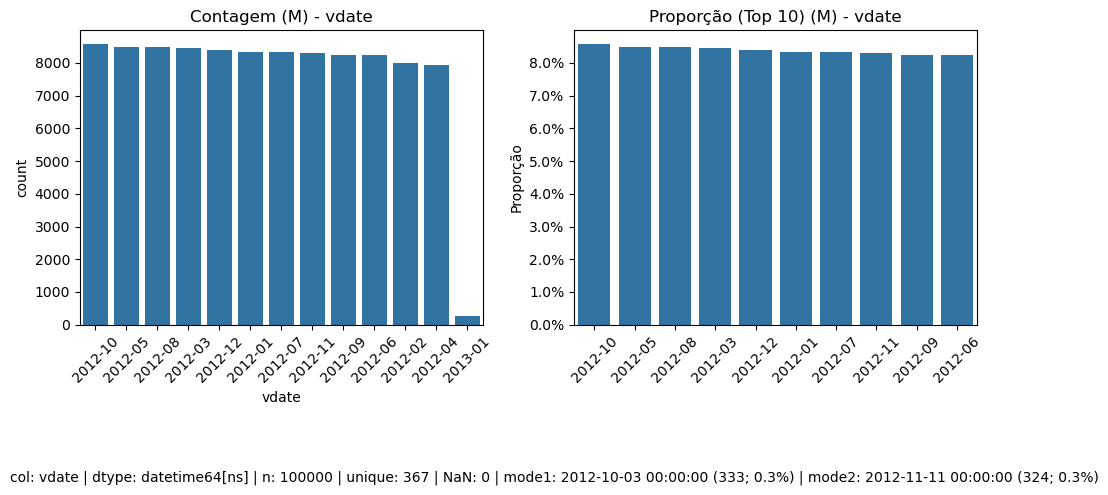

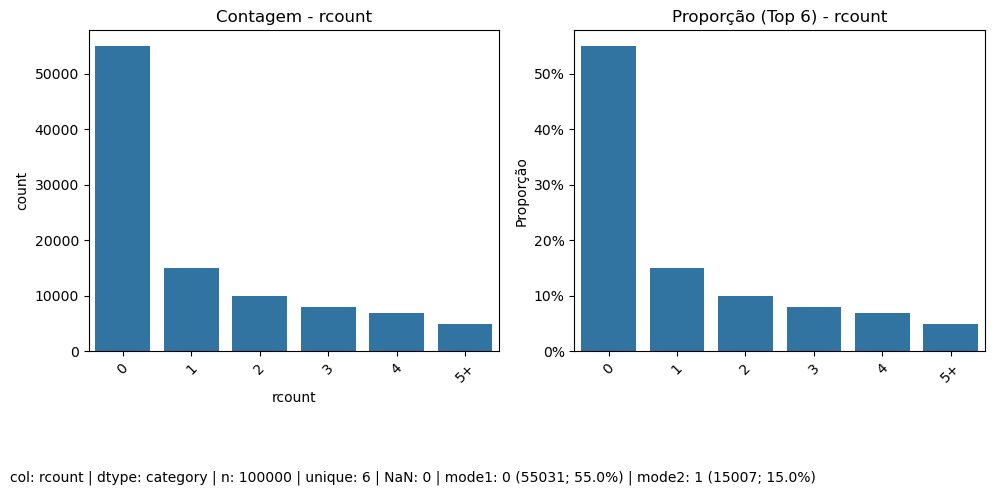

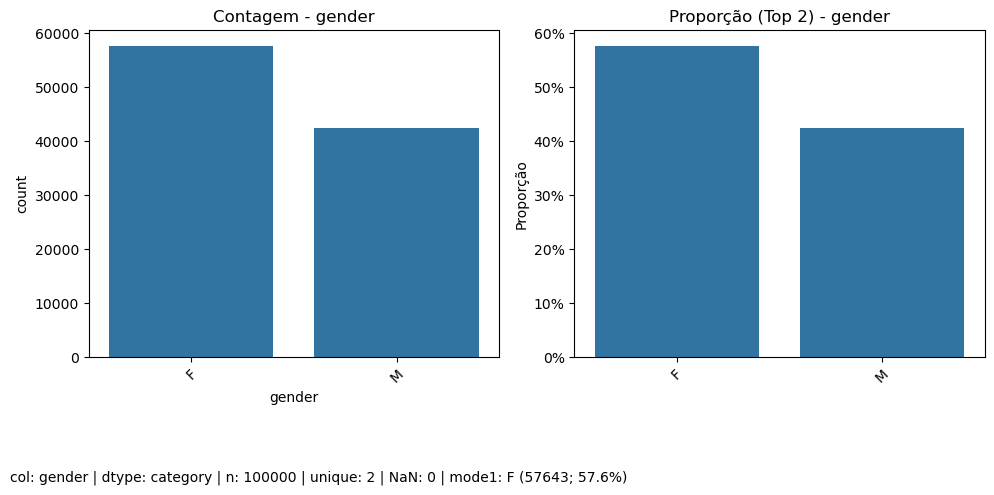

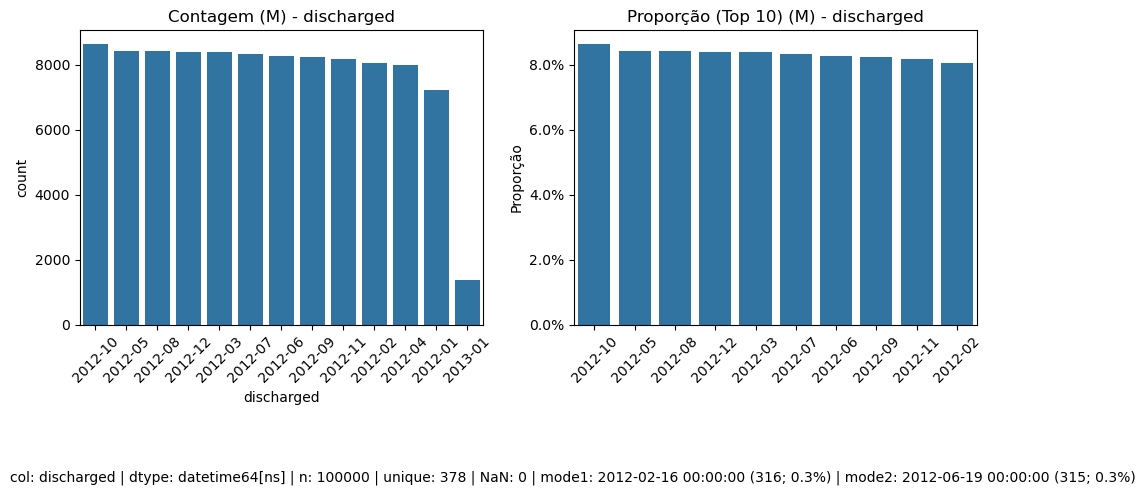

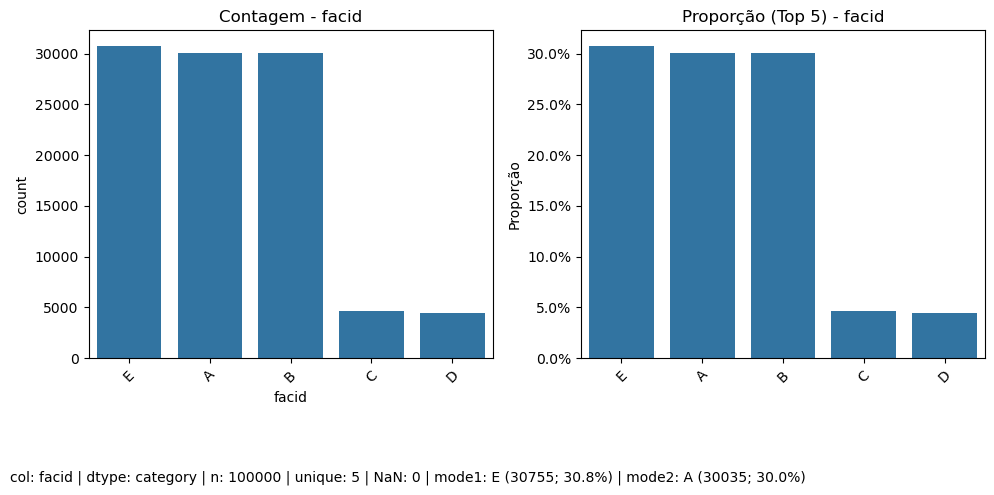

['- [x] categorical | Categóricas: Mapear distribuição, top-N, raras, rótulos e nulos.',
 '- [ ] numerical | Numéricas: Resumo, hist/box, outliers, assimetria.',
 '- [ ] datetime | Datas: Granularidade, gaps, ranges, sazonalidade.',
 '- [ ] missing | Missing: Taxa por coluna/linha, padrões e plano de tratamento.',
 '- [ ] duplicates | Duplicatas: Linhas/IDs repetidos, chaves e integridade.',
 '- [ ] cardinality | Cardinalidade: IDs disfarçados, alto nº de categorias.',
 '- [ ] relationships | Relações: Num↔num, cat↔num, cat↔cat.',
 '- [ ] time | Temporal: Tendência, quebras, sazonalidade, estacionariedade.',
 '- [ ] target | Target: Distribuição, desbalanceamento, fuga de informação.',
 '- [ ] leakage | Leakage: Variáveis posteriores ao evento, proxies do rótulo.',
 '- [ ] sampling_bias | Amostragem: Representatividade, períodos, viés de seleção.',
 '- [ ] docs | Documentação: Decisões, exclusões, tratamentos e pendências.']

In [21]:
categorical_plot(df_entry)
eda_steps(categorical = True)

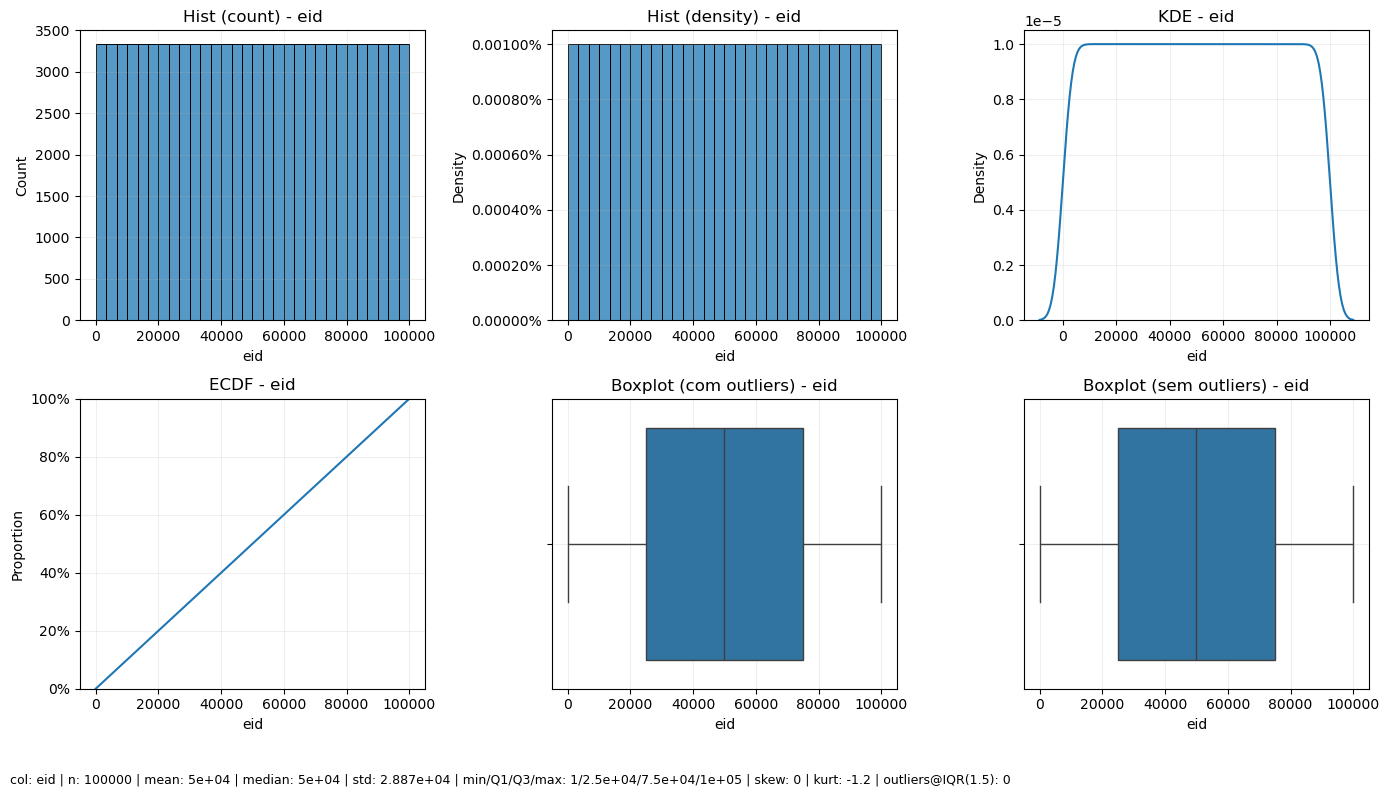

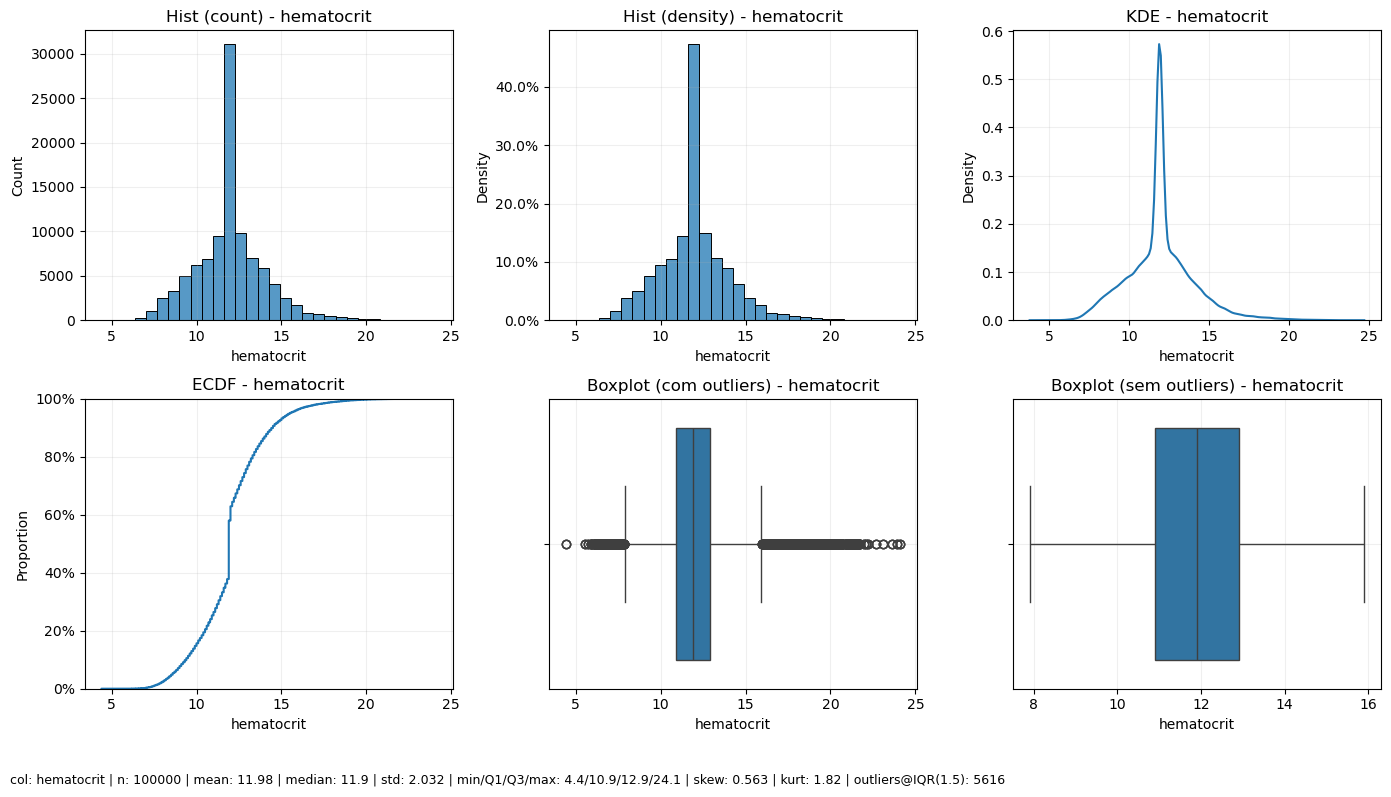

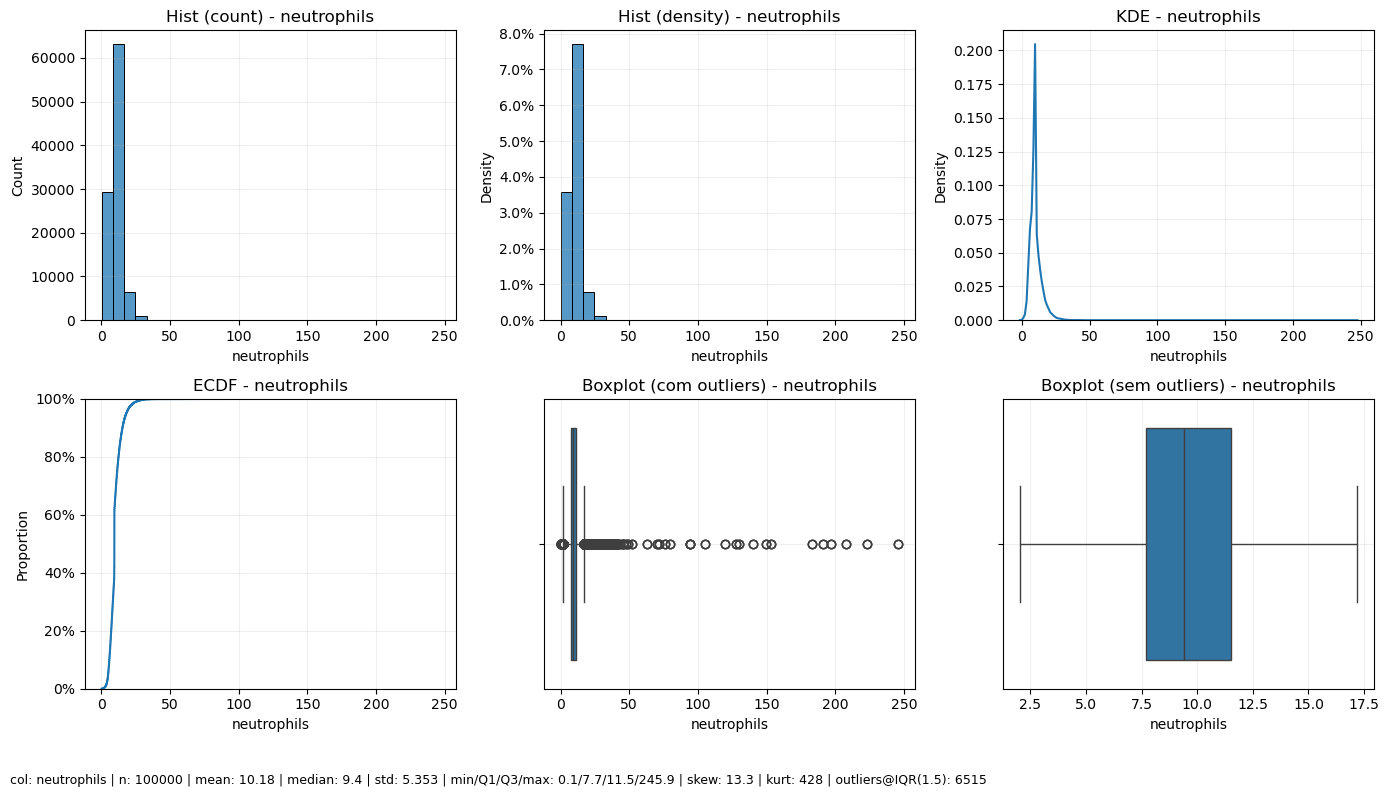

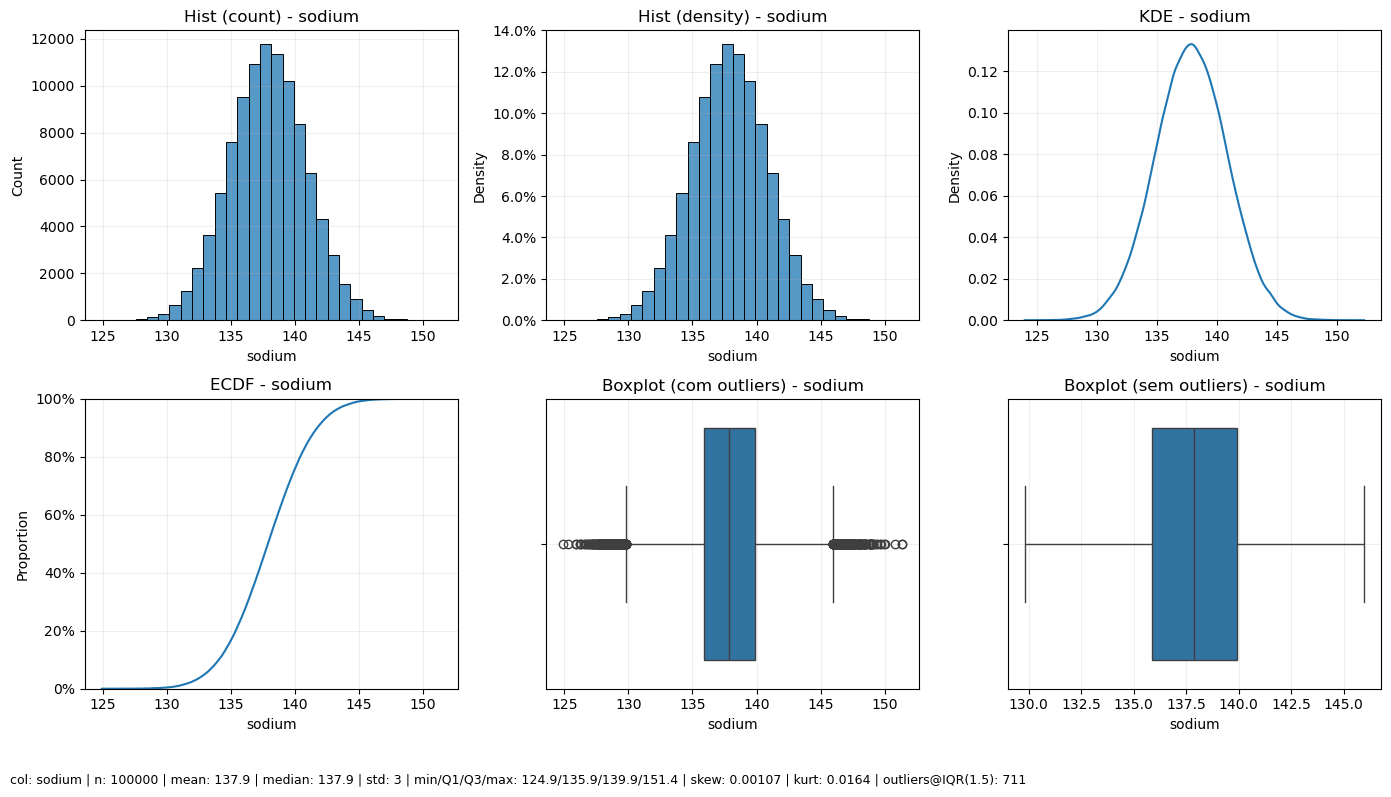

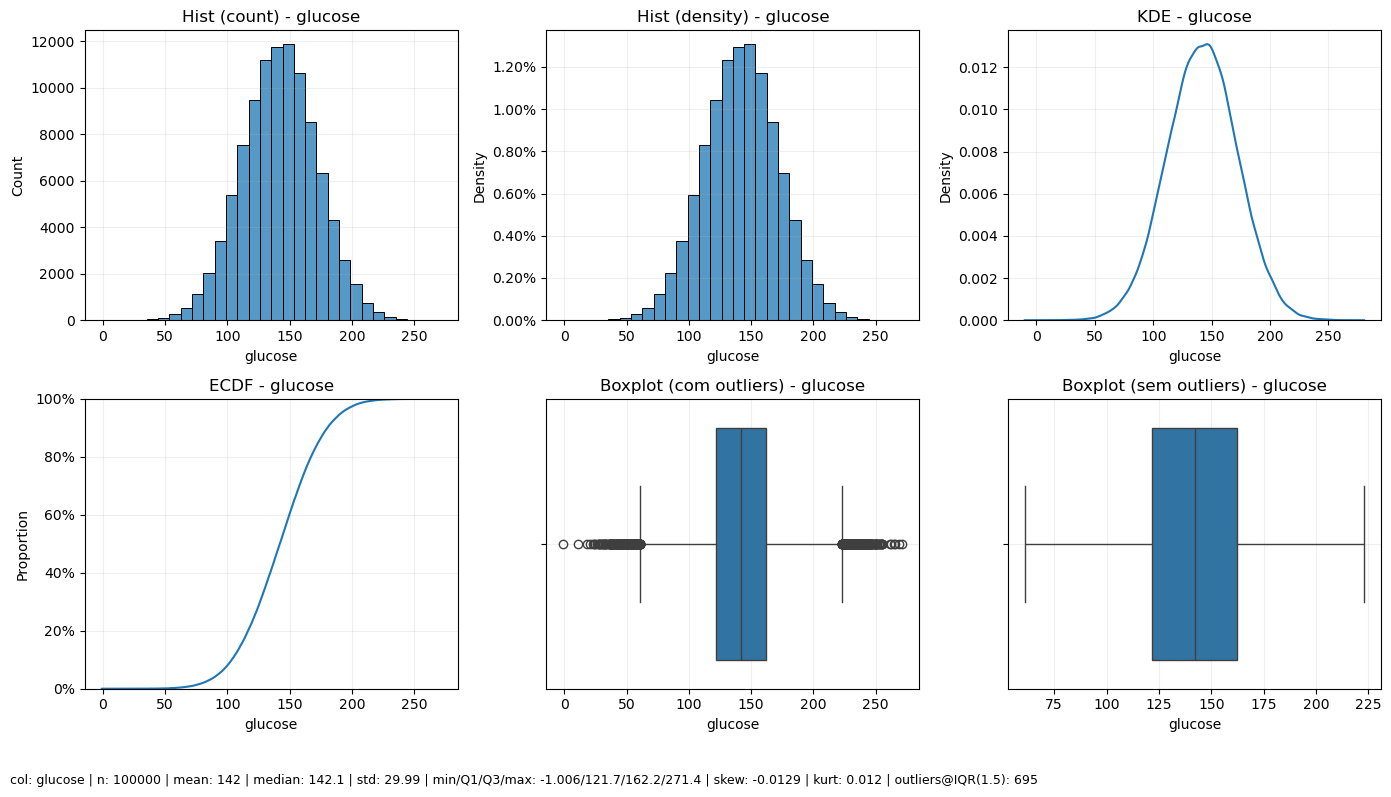

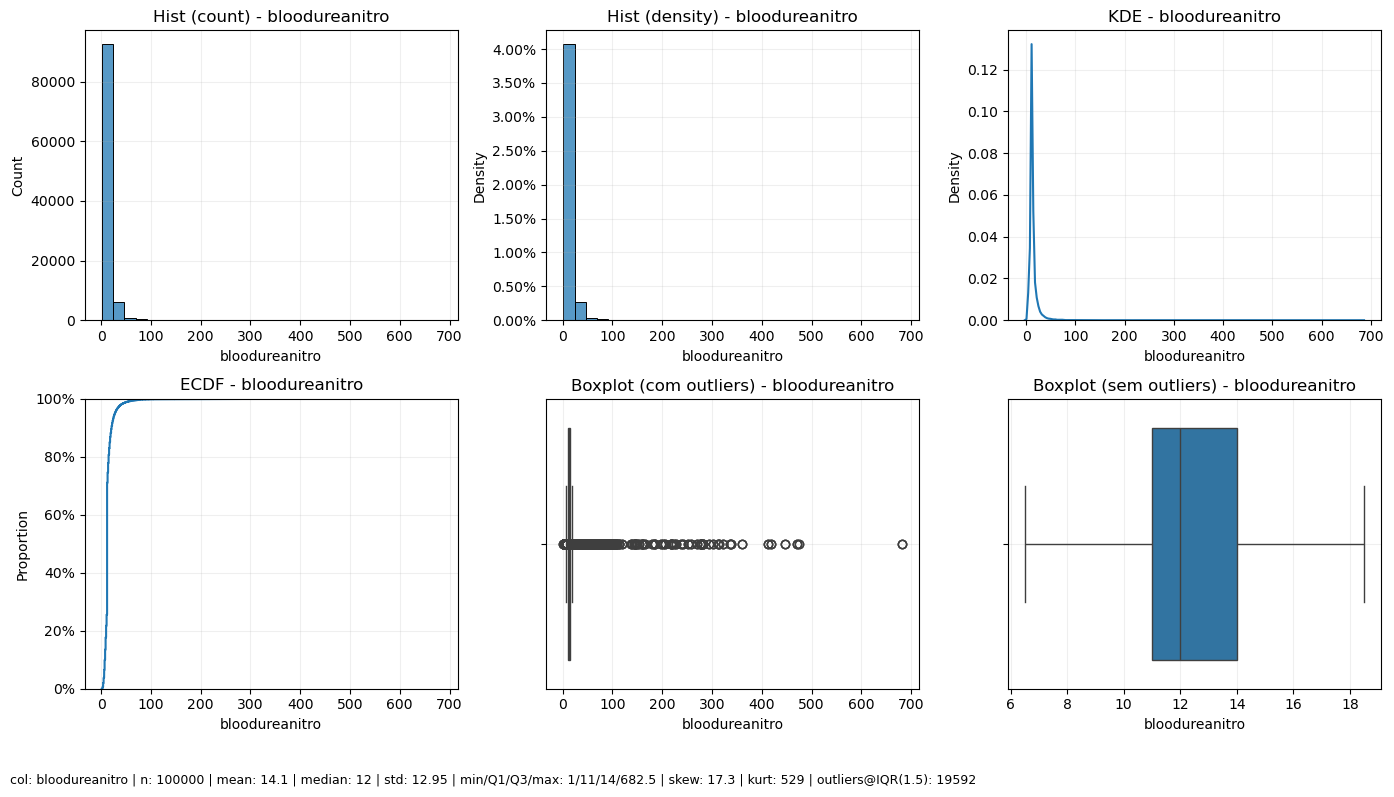

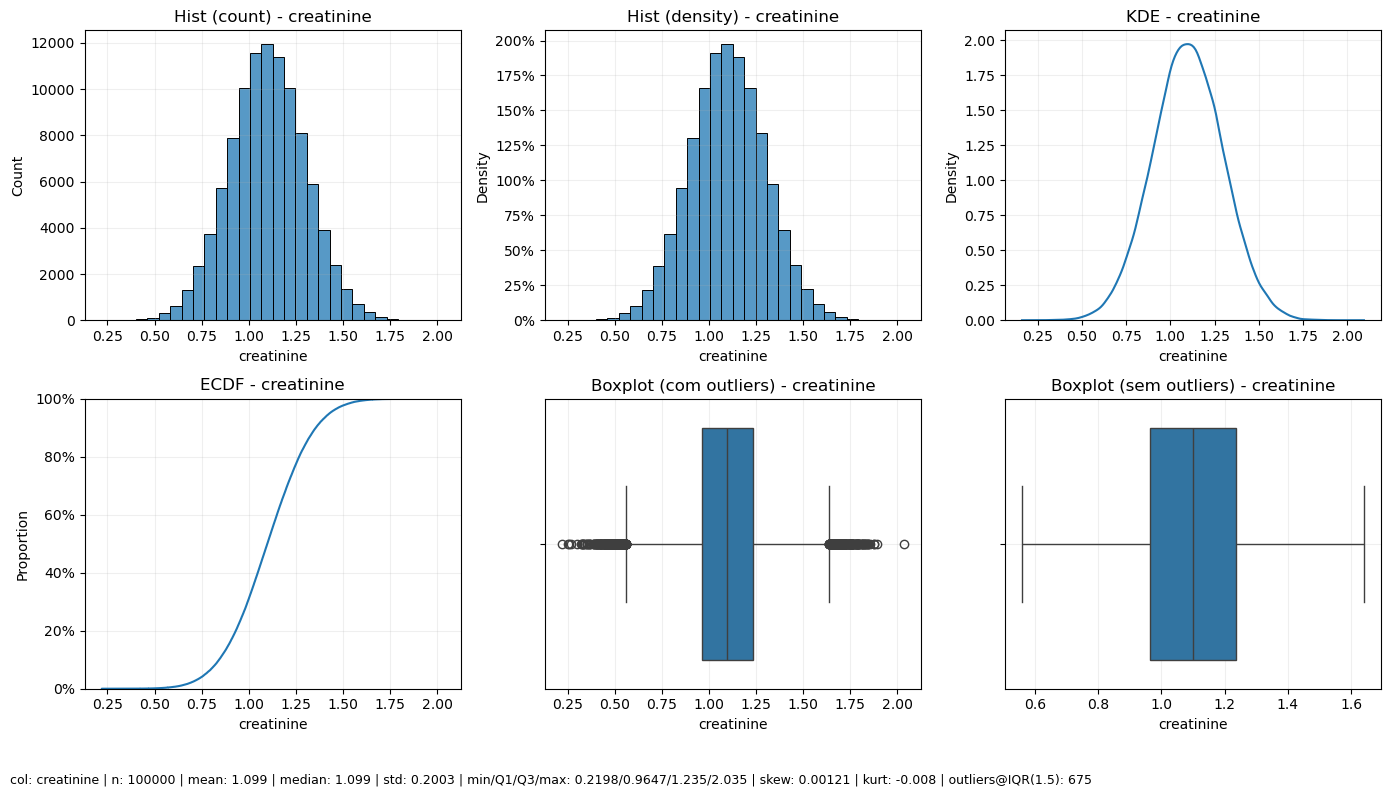

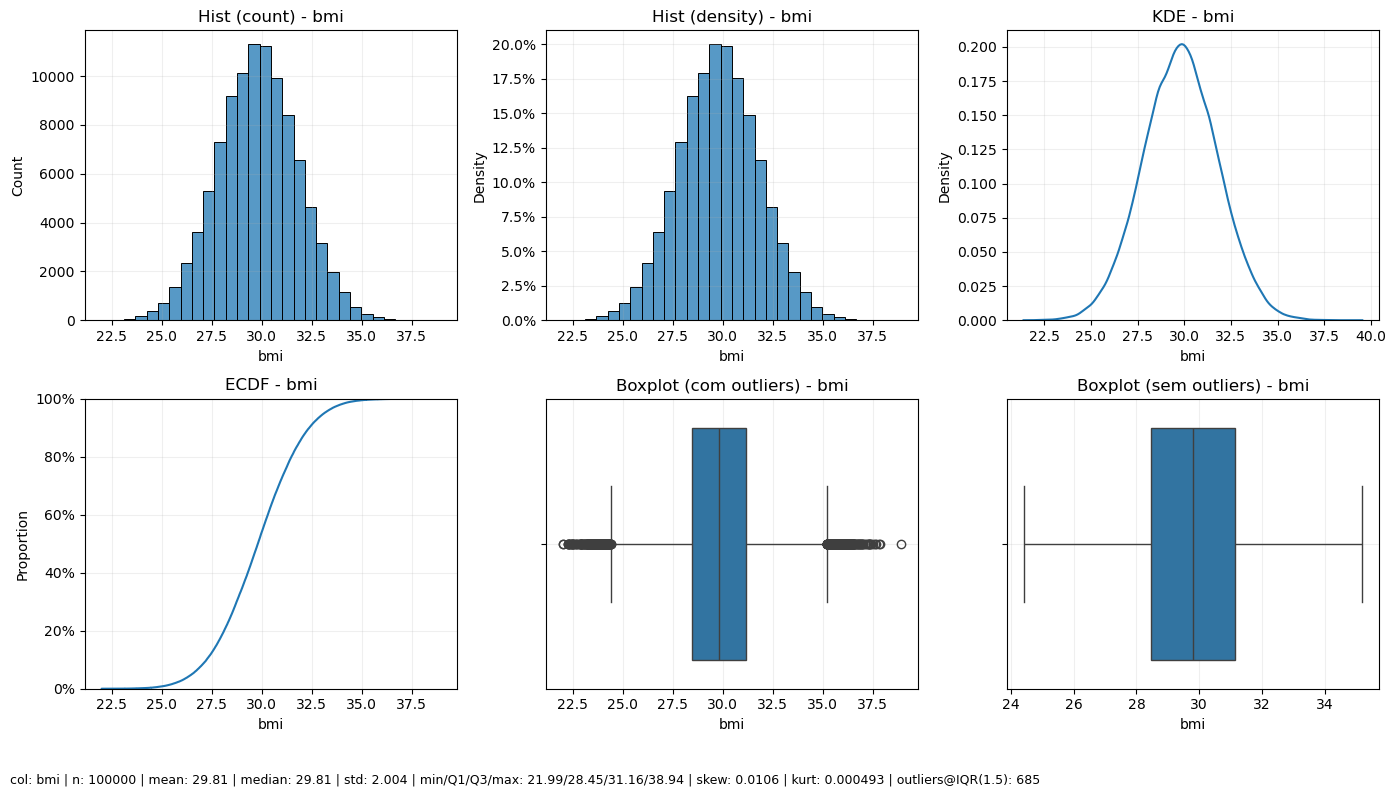

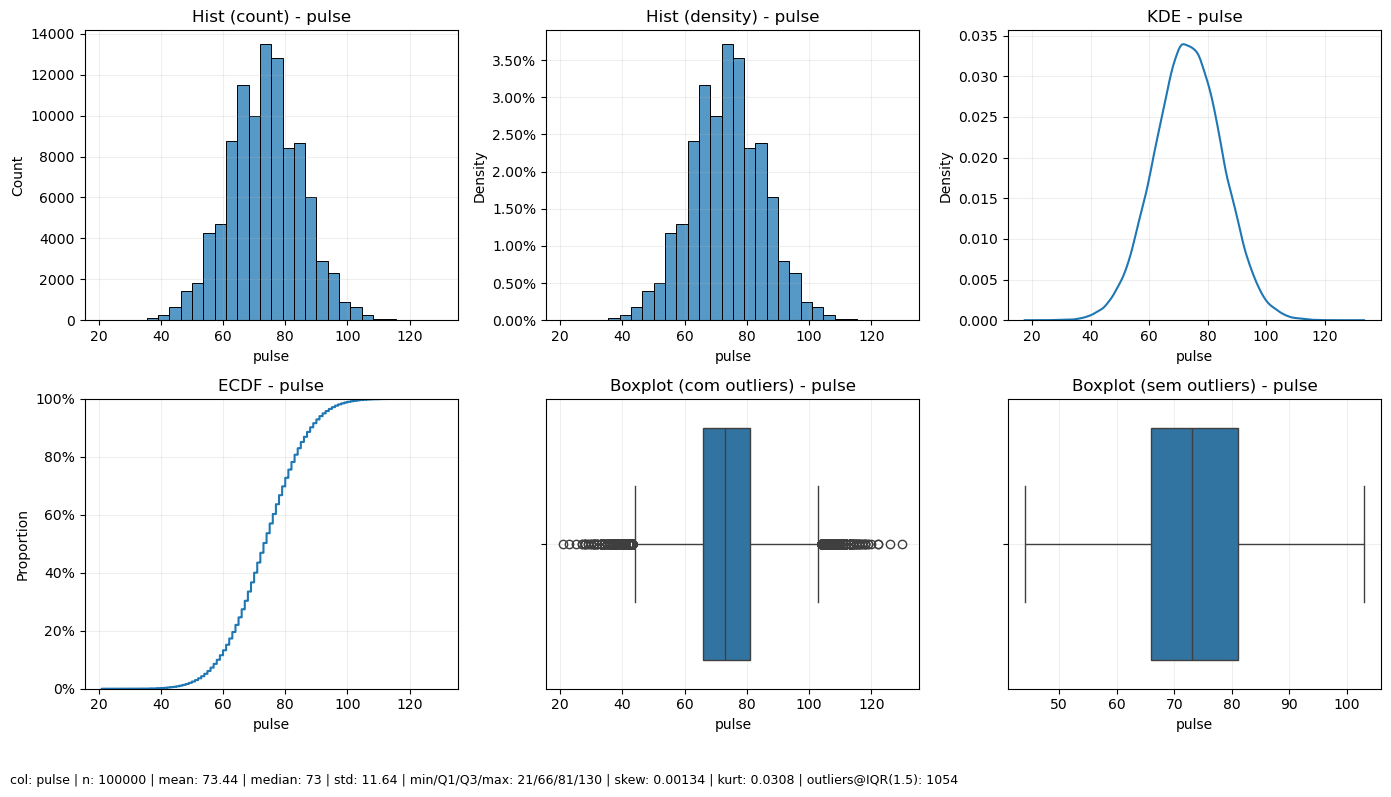

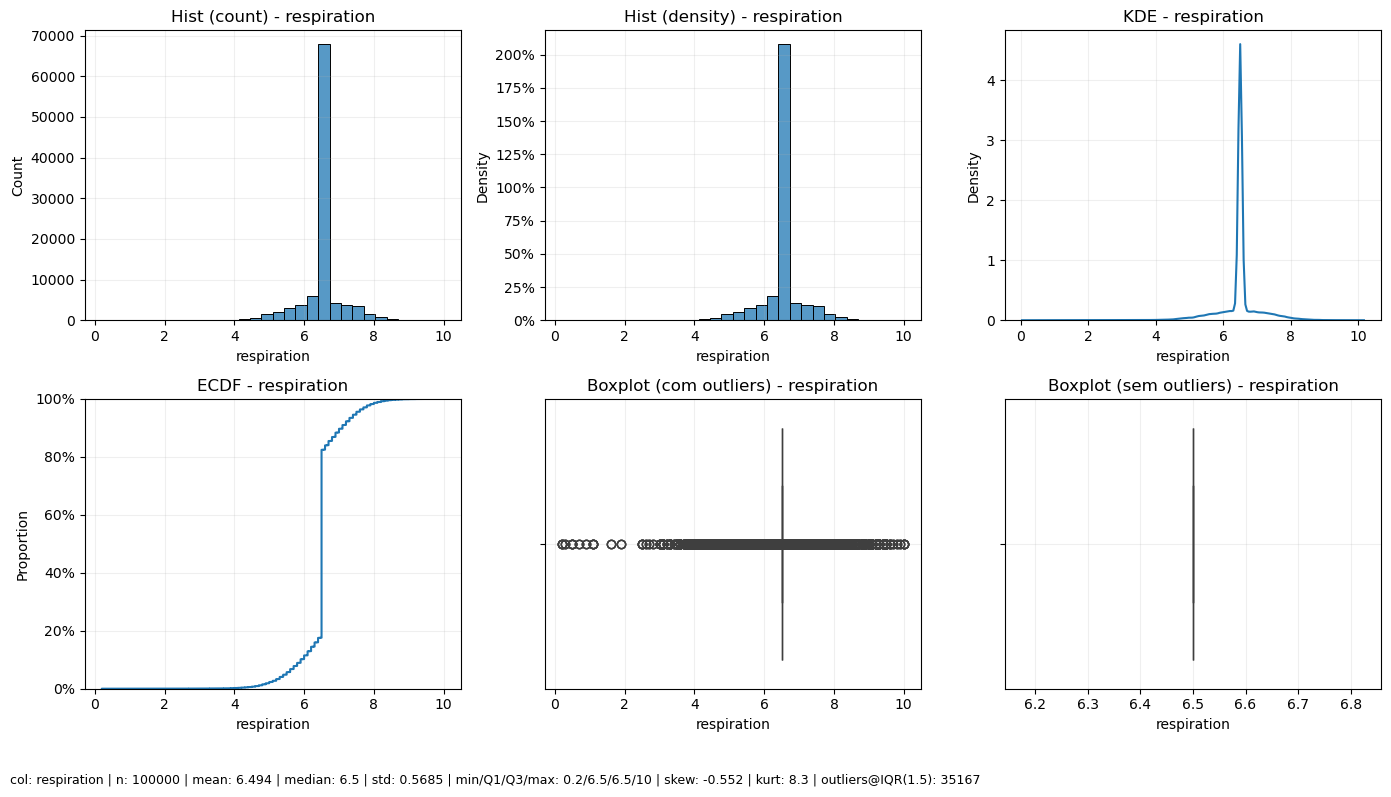

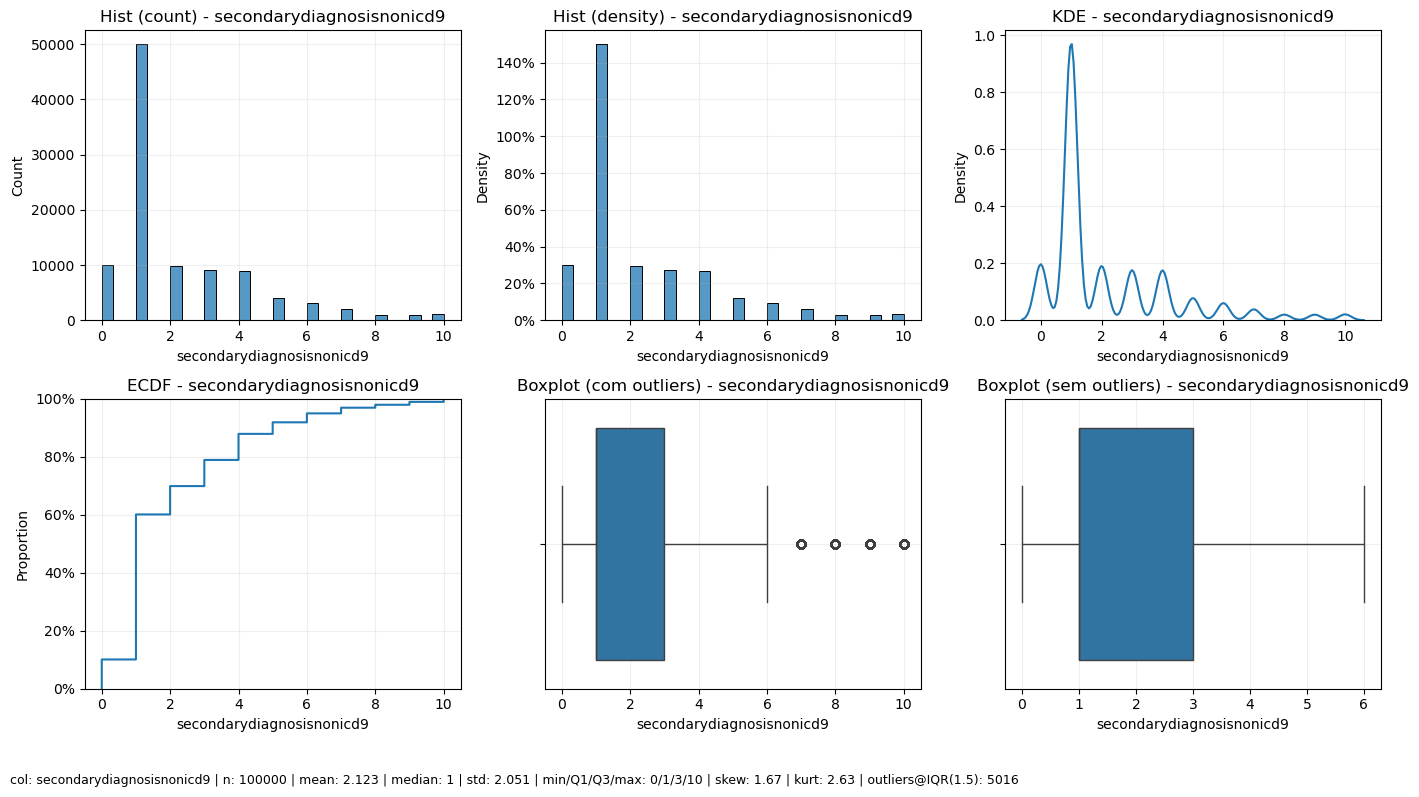

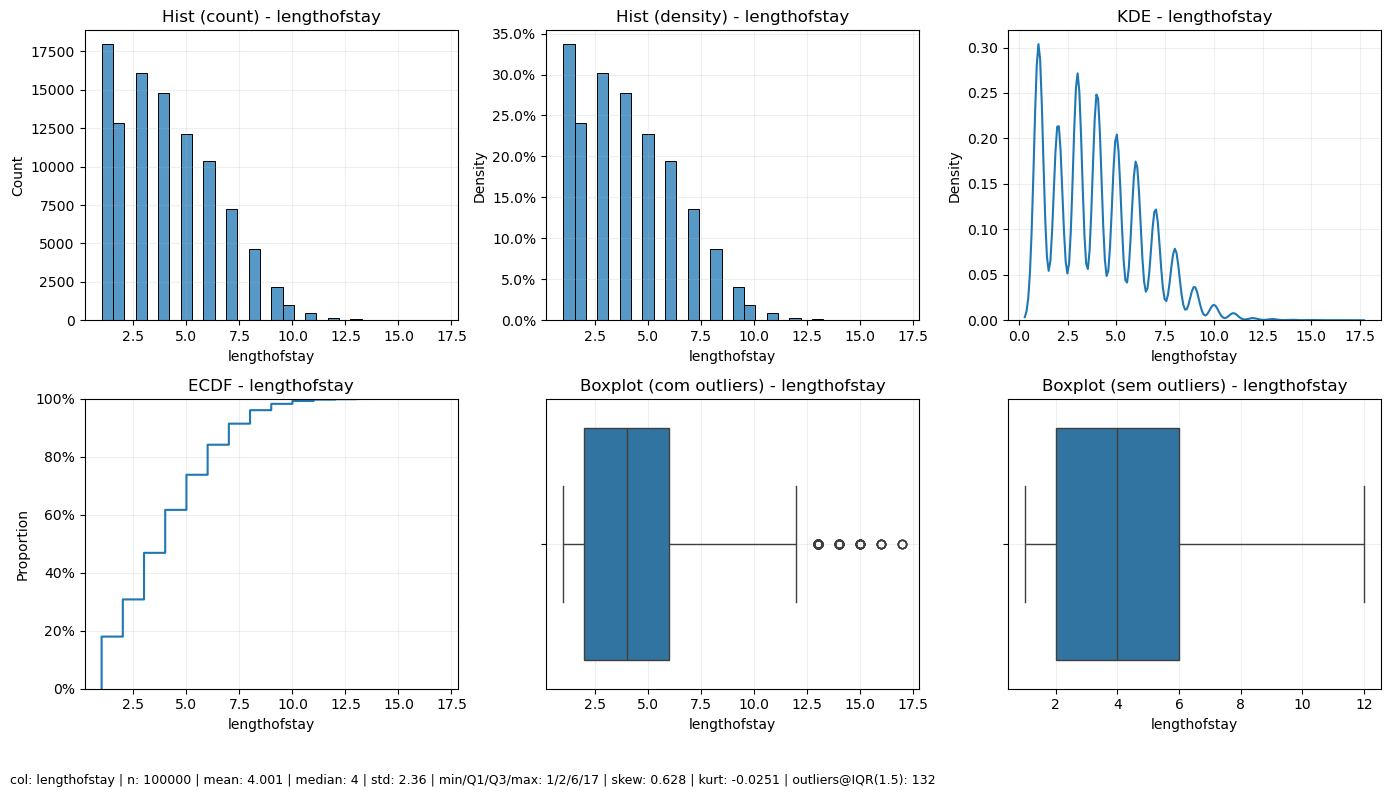

['- [x] categorical | Categóricas: Mapear distribuição, top-N, raras, rótulos e nulos.',
 '- [x] numerical | Numéricas: Resumo, hist/box, outliers, assimetria.',
 '- [ ] datetime | Datas: Granularidade, gaps, ranges, sazonalidade.',
 '- [ ] missing | Missing: Taxa por coluna/linha, padrões e plano de tratamento.',
 '- [ ] duplicates | Duplicatas: Linhas/IDs repetidos, chaves e integridade.',
 '- [ ] cardinality | Cardinalidade: IDs disfarçados, alto nº de categorias.',
 '- [ ] relationships | Relações: Num↔num, cat↔num, cat↔cat.',
 '- [ ] time | Temporal: Tendência, quebras, sazonalidade, estacionariedade.',
 '- [ ] target | Target: Distribuição, desbalanceamento, fuga de informação.',
 '- [ ] leakage | Leakage: Variáveis posteriores ao evento, proxies do rótulo.',
 '- [ ] sampling_bias | Amostragem: Representatividade, períodos, viés de seleção.',
 '- [ ] docs | Documentação: Decisões, exclusões, tratamentos e pendências.']

In [22]:
numerical_plot(df_entry)
eda_steps(categorical = True, numerical = True)

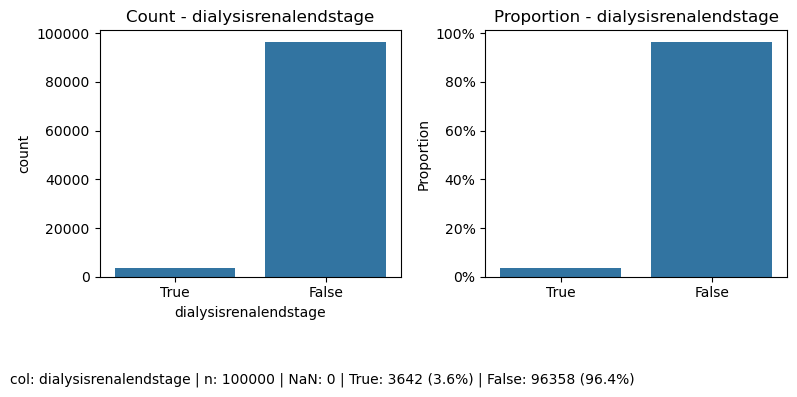

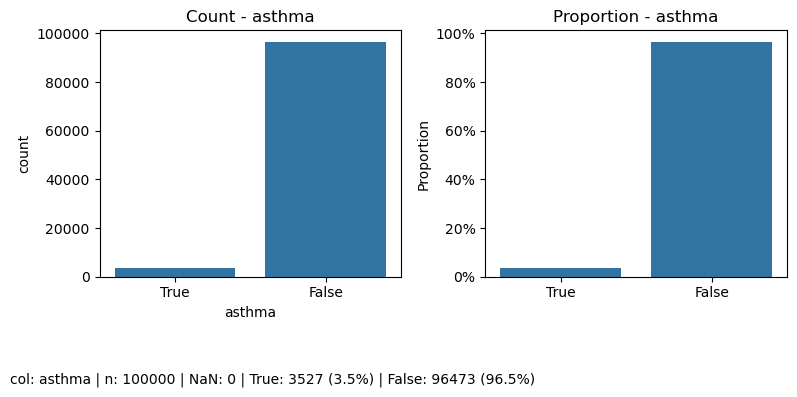

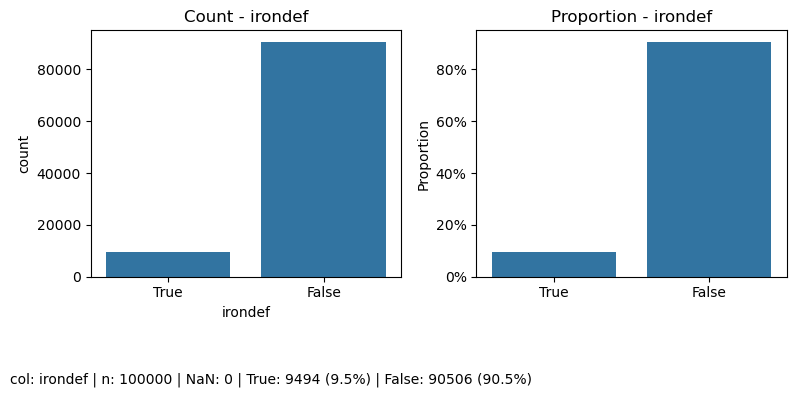

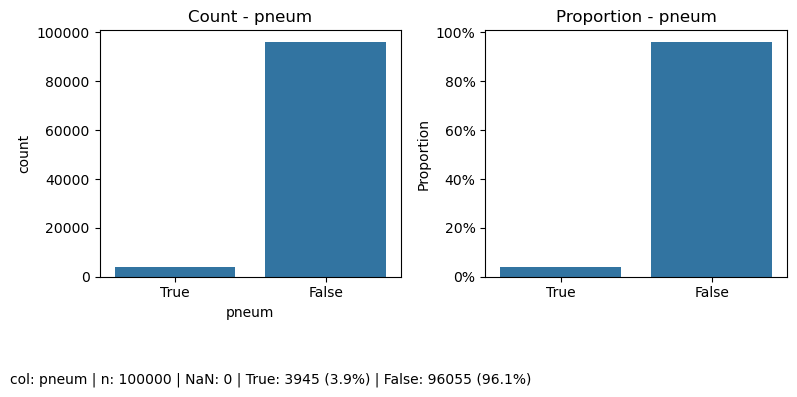

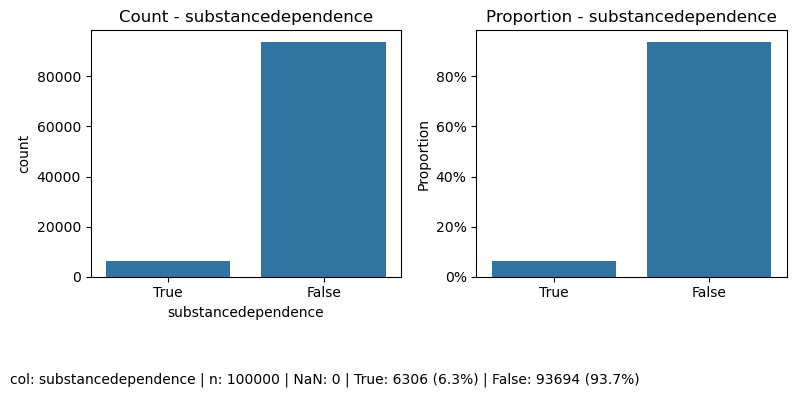

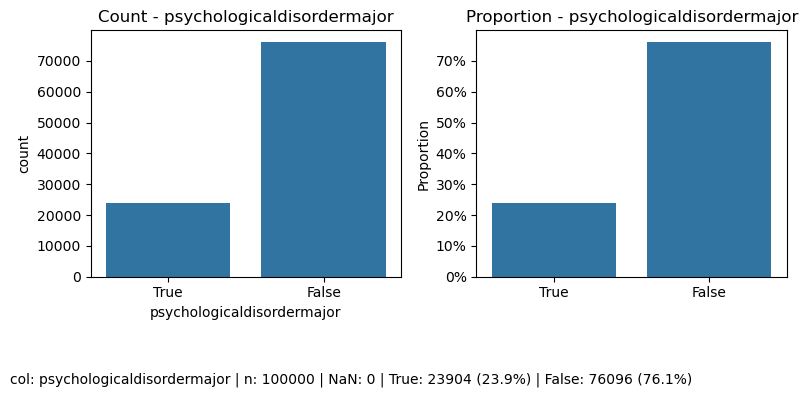

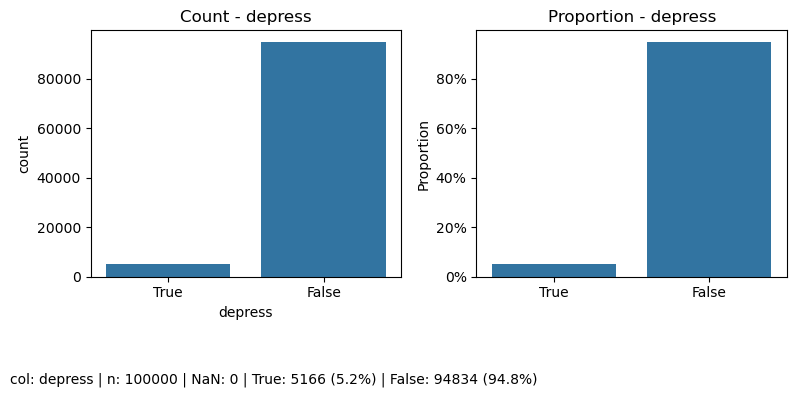

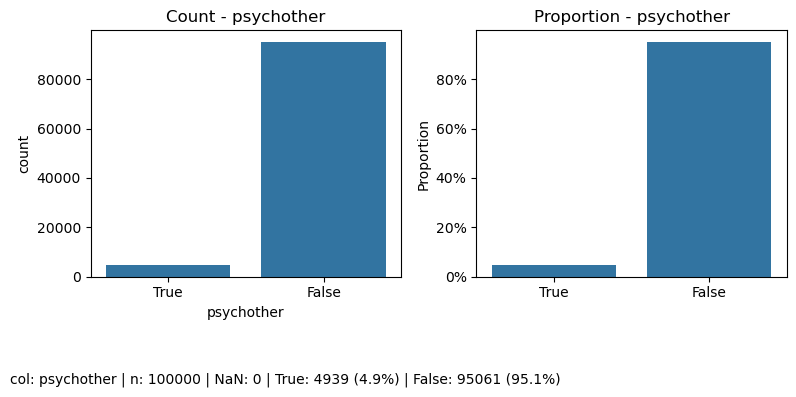

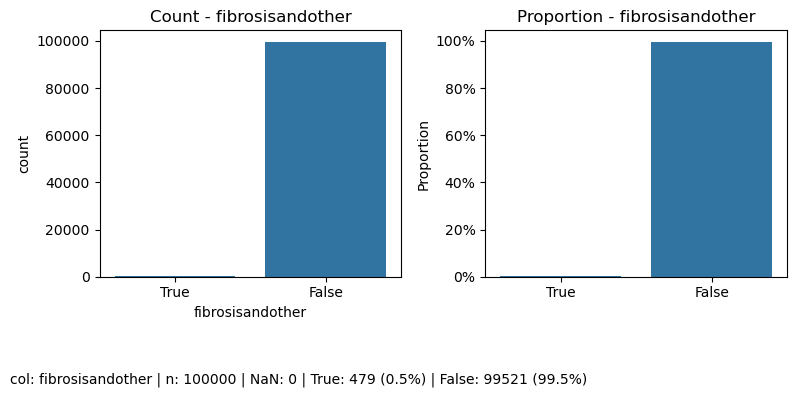

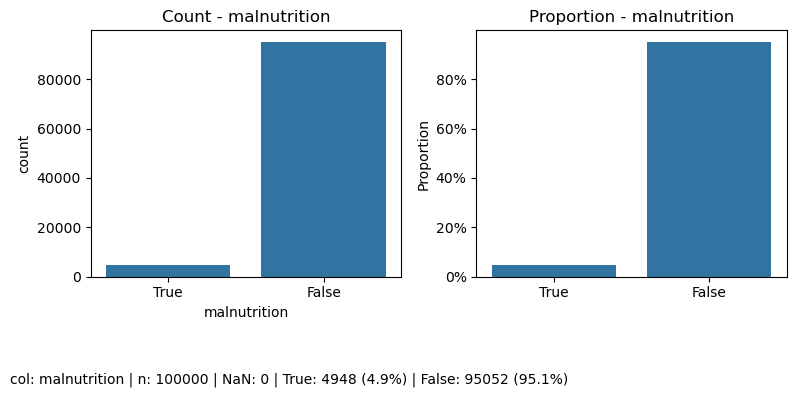

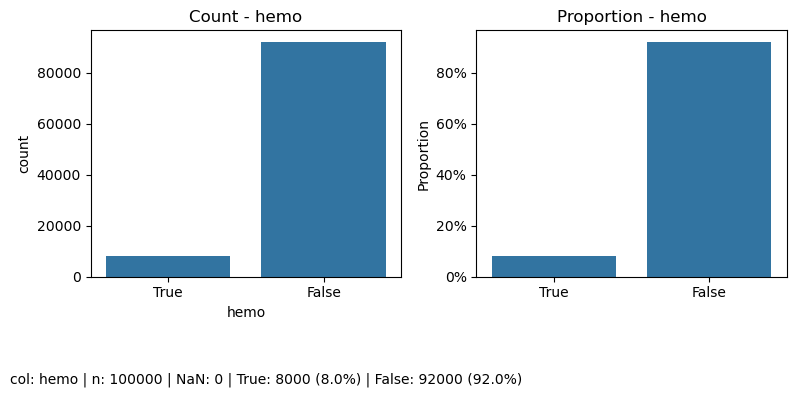

In [23]:
boolean_plot(df_entry)

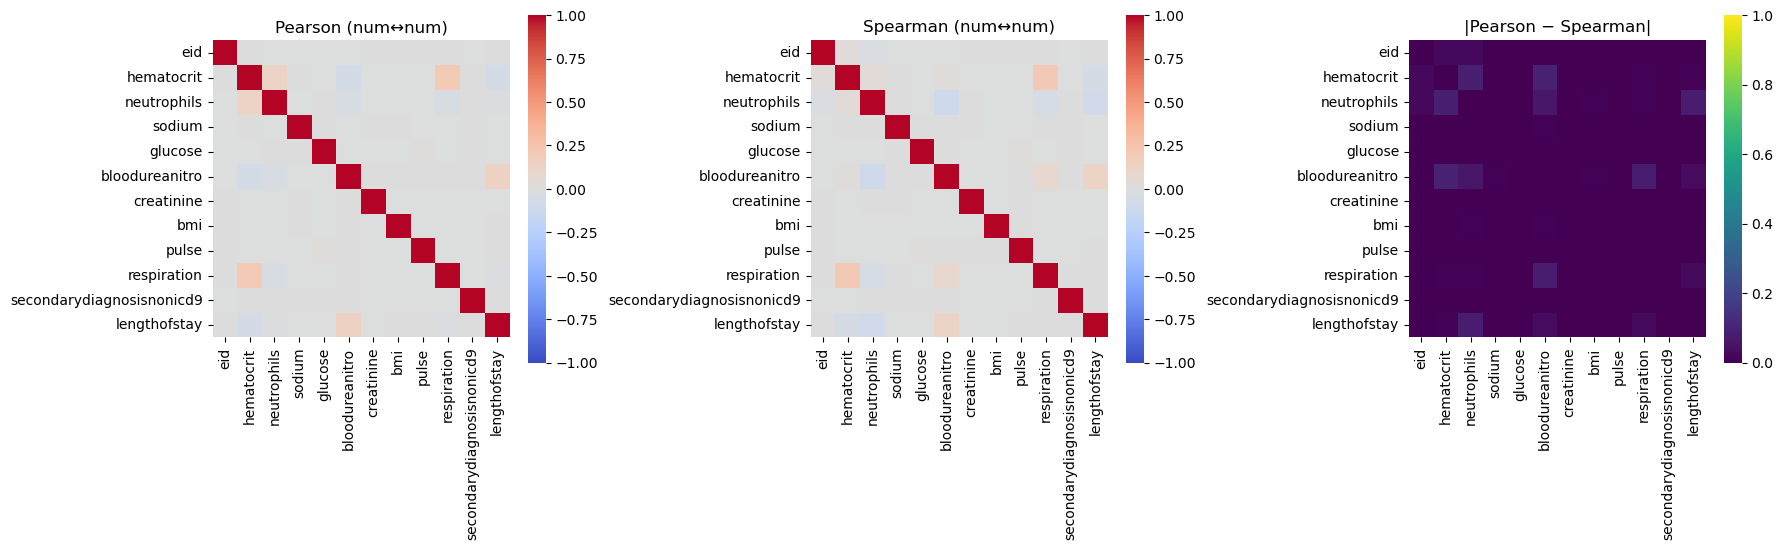

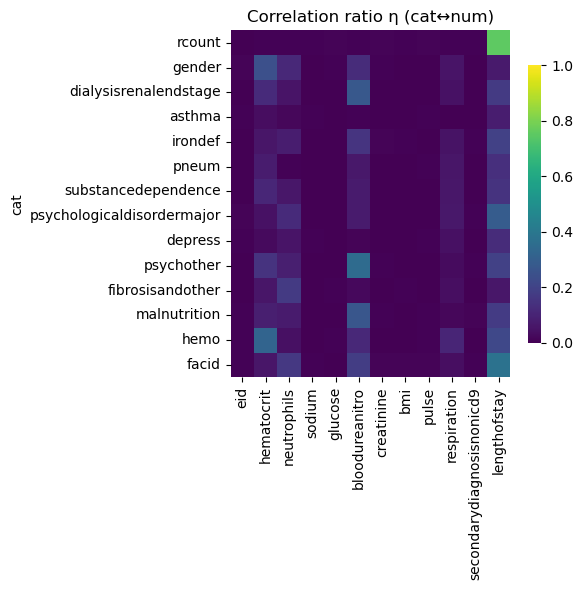

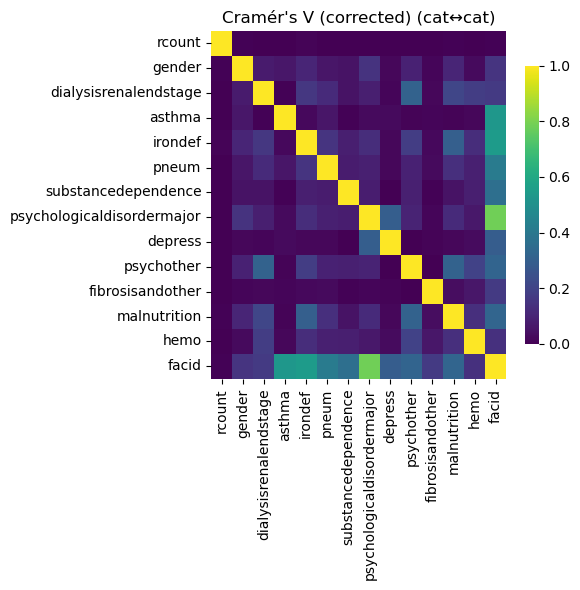

Num↔Num — Top |Pearson|:
  hematocrit ~ respiration: r=0.206 (n=100000)
  bloodureanitro ~ lengthofstay: r=0.148 (n=100000)
  hematocrit ~ neutrophils: r=0.122 (n=100000)
  hematocrit ~ bloodureanitro: r=-0.074 (n=100000)
  hematocrit ~ lengthofstay: r=-0.064 (n=100000)
  neutrophils ~ bloodureanitro: r=-0.045 (n=100000)
  neutrophils ~ respiration: r=-0.044 (n=100000)
  respiration ~ lengthofstay: r=-0.022 (n=100000)
  neutrophils ~ lengthofstay: r=-0.011 (n=100000)
  glucose ~ pulse: r=0.008 (n=100000)
Cat↔Num — Top η:
  rcount → lengthofstay: η=0.751 (n=100000)
  facid → lengthofstay: η=0.377 (n=100000)
  psychother → bloodureanitro: η=0.347 (n=100000)
  hemo → hematocrit: η=0.317 (n=100000)
  psychologicaldisordermajor → lengthofstay: η=0.287 (n=100000)
  dialysisrenalendstage → bloodureanitro: η=0.272 (n=100000)
  malnutrition → bloodureanitro: η=0.268 (n=100000)
  gender → hematocrit: η=0.243 (n=100000)
  hemo → lengthofstay: η=0.218 (n=100000)
  irondef → lengthofstay: η=0.194 (

['- [x] categorical | Categóricas: Mapear distribuição, top-N, raras, rótulos e nulos.',
 '- [x] numerical | Numéricas: Resumo, hist/box, outliers, assimetria.',
 '- [ ] datetime | Datas: Granularidade, gaps, ranges, sazonalidade.',
 '- [ ] missing | Missing: Taxa por coluna/linha, padrões e plano de tratamento.',
 '- [ ] duplicates | Duplicatas: Linhas/IDs repetidos, chaves e integridade.',
 '- [ ] cardinality | Cardinalidade: IDs disfarçados, alto nº de categorias.',
 '- [x] relationships | Relações: Num↔num, cat↔num, cat↔cat.',
 '- [ ] time | Temporal: Tendência, quebras, sazonalidade, estacionariedade.',
 '- [ ] target | Target: Distribuição, desbalanceamento, fuga de informação.',
 '- [ ] leakage | Leakage: Variáveis posteriores ao evento, proxies do rótulo.',
 '- [ ] sampling_bias | Amostragem: Representatividade, períodos, viés de seleção.',
 '- [ ] docs | Documentação: Decisões, exclusões, tratamentos e pendências.']

In [24]:
relationship_map(df_entry)
eda_steps(categorical= True, numerical= True, relationships= True)

<h4> target </h4>

C:\Users\Maico\AppData\Local\Temp\ipykernel_7776\2984549934.py:95: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  is_cat = pd.api.types.is_categorical_dtype(s) or pd.api.types.is_bool_dtype(s) or pd.api.types.is_object_dtype(s)


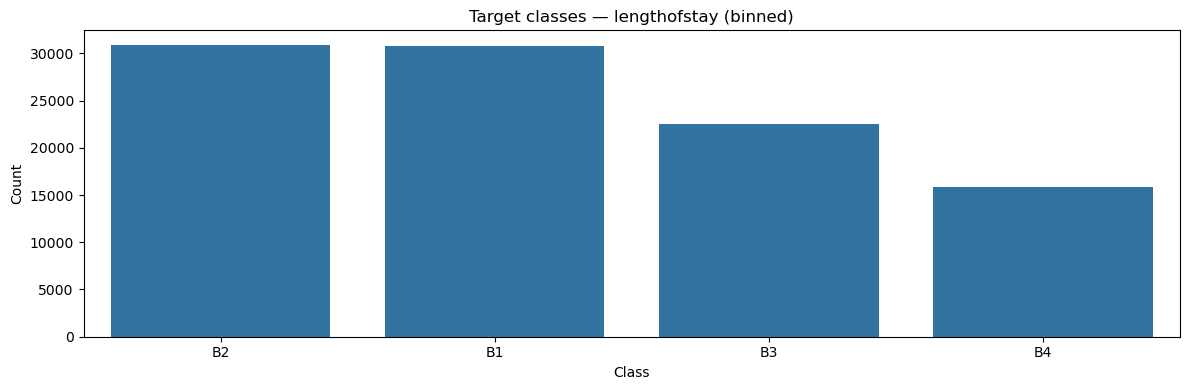

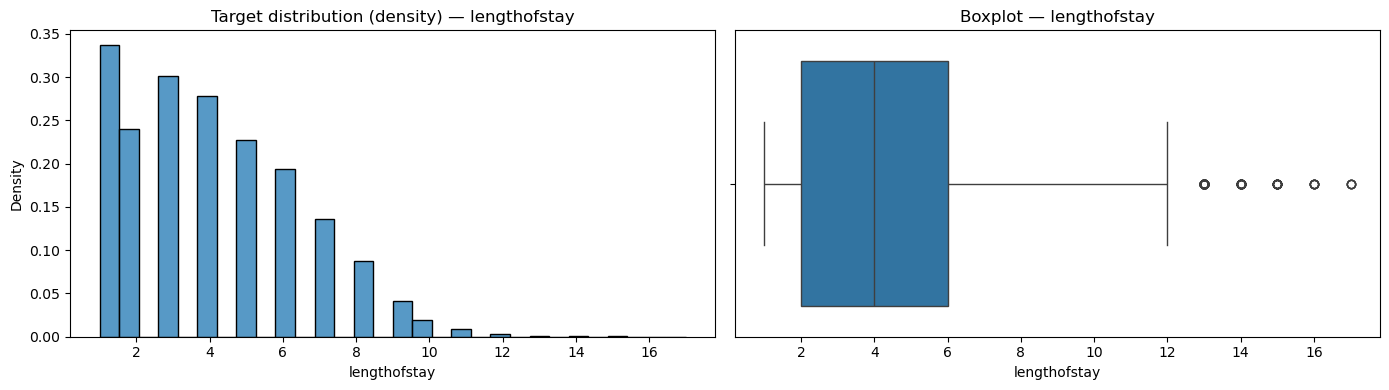

['- [x] categorical | Categóricas: Mapear distribuição, top-N, raras, rótulos e nulos.',
 '- [x] numerical | Numéricas: Resumo, hist/box, outliers, assimetria.',
 '- [ ] datetime | Datas: Granularidade, gaps, ranges, sazonalidade.',
 '- [ ] missing | Missing: Taxa por coluna/linha, padrões e plano de tratamento.',
 '- [ ] duplicates | Duplicatas: Linhas/IDs repetidos, chaves e integridade.',
 '- [ ] cardinality | Cardinalidade: IDs disfarçados, alto nº de categorias.',
 '- [x] relationships | Relações: Num↔num, cat↔num, cat↔cat.',
 '- [ ] time | Temporal: Tendência, quebras, sazonalidade, estacionariedade.',
 '- [x] target | Target: Distribuição, desbalanceamento, fuga de informação.',
 '- [ ] leakage | Leakage: Variáveis posteriores ao evento, proxies do rótulo.',
 '- [ ] sampling_bias | Amostragem: Representatividade, períodos, viés de seleção.',
 '- [ ] docs | Documentação: Decisões, exclusões, tratamentos e pendências.']

In [25]:

out = validate_target(df_entry, "lengthofstay", task="both", show_plots=True)


eda_steps(categorical= True, numerical= True, relationships= True, target= True)

In [26]:
print_target_summary(out)

task: both | is_numeric: True | NA: 0

[Classification]
classes:
lengthofstay
B2    30890
B1    30804
B3    22478
B4    15828
Name: count, dtype: int64
binning: quantile:4 | edges: [1.0, 2.0, 4.0, 6.0, 17.0]

[Regression]
n=100000 | mean=4 | median=4 | std=2.36 | min=1 | q1=2 | q3=6 | max=17
skew=0.628 | kurt=-0.0251 | outliers_IQR=132
baselines: MAE@median=1.91 | RMSE@mean=2.36

[Recommendations]
- Outliers detected by IQR (n=132). Review capping/winsorization policy.
- Choose cross-validation consistent with the data (Stratified for classes, GroupKFold for grouped data, TimeSeriesSplit for temporal).
- Document target definition, binning (if any), and rationale for metrics used.


<h2> Modelo </h2>

In [27]:
datetime_cols = ["vdate", "discharged"]
cat_cols = ["gender", "rcount", "facid"]
bin_cols = ["dialysisrenalendstage", 
            "asthma", 
            "irondef", 
            "pneum", 
            "substancedependence", 
            "psychologicaldisordermajor",
            "depress",
            "psychother",
            "fibrosisandother",
            "malnutrition",
            "hemo"]
num_cols = ["hematocrit",
            "neutrophils",
            "sodium",
            "glucose",
            "bloodureanitro",
            "creatinine",
            "bmi",
            "respiration"]

In [28]:
df_entry["rcount"] = (
    df_entry["rcount"].astype(str).str.replace(r"\+$", "", regex=True)
    .pipe(pd.to_numeric, errors="coerce")
)

In [29]:
y = df_entry["lengthofstay"]
X = df_entry.drop(["lengthofstay", "discharged", "vdate", "eid"], axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),              
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
], remainder="drop") 

regressor = make_pipeline(pre, LGBMRegressor(n_jobs=-1, random_state=42))
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 21
[LightGBM] [Info] Start training from score 4.001762
MAE: 0.5005351462289782
RMSE: 0.5016706496338873
R2: 0.9085743221168201


<h4> Avaliação </h4>

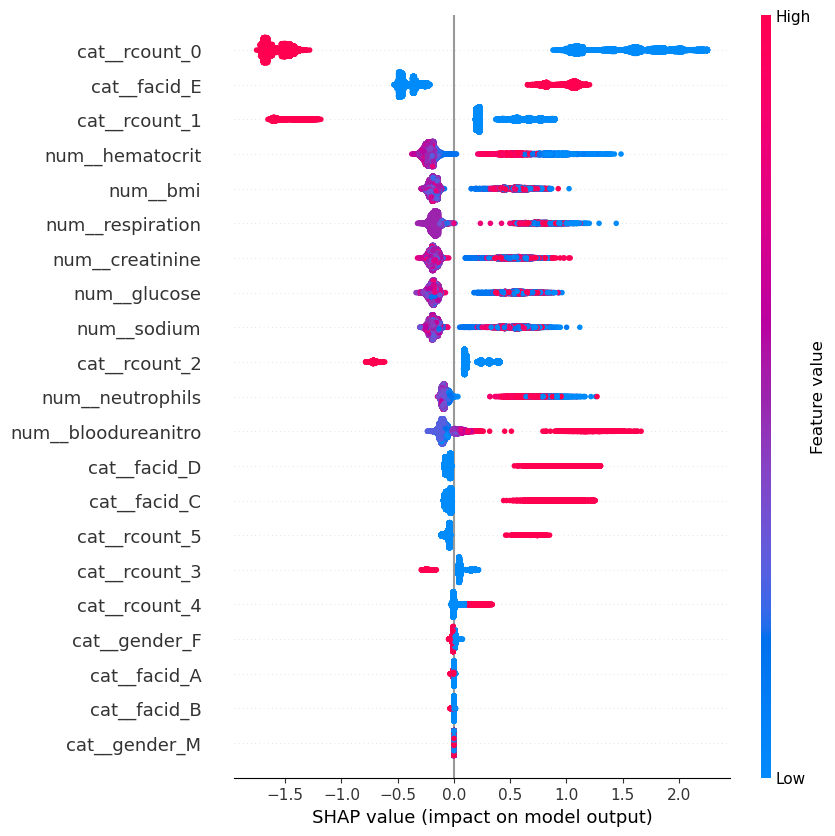

In [32]:
explainer = shap.Explainer(regressor[1], feature_names=regressor[0].get_feature_names_out())
X_obs = regressor[0].transform(X_test)
shap_values = explainer(X_obs)
shap.plots.beeswarm(shap_values, max_display=30)

In [33]:
y_shuf = y.sample(frac=1.0, random_state=42).reset_index(drop=True)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = -cross_val_score(regressor, X, y_shuf, cv=cv, scoring="neg_mean_absolute_error")
print("MAE shuffled:", scores.mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 21
[LightGBM] [Info] Start training from score 4.004700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 21
[LightGBM] [Info] Start training from score 3.993638
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set

In [34]:
order = df_entry["vdate"].argsort()
Xo, yo = X.iloc[order], y.iloc[order]

tss = TimeSeriesSplit(n_splits=5)
mae_tss = -cross_val_score(regressor, Xo, yo, cv=tss, scoring="neg_mean_absolute_error")
print("MAE TSS:", mae_tss.mean(), mae_tss.std())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 16670, number of used features: 21
[LightGBM] [Info] Start training from score 3.976845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 33336, number of used features: 21
[LightGBM] [Info] Start training from score 3.994060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

In [35]:
#for c in X.columns:
#    pipe = make_pipeline(
#        ColumnTransformer([("one", "passthrough", [c])], remainder="drop"),
#        LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1),
#    )
#    mae = -cross_val_score(pipe, X[[c]], y, cv=5, scoring="neg_mean_absolute_error").mean()
#    print(f"{c}: MAE={mae:.3f}")

In [36]:
def regression_diagnostics(
    y_true,
    y_pred,
    *,
    bins: int = 20,
    sample: int | None = 50000,
    figsize: tuple[int, int] = (12, 10),
    min_bin_size: int = 30,
) -> None:
    """
    Painel 2×2 de diagnóstico para regressão: y vs ŷ, resíduos vs ŷ, calibração binned e hist de resíduos.

    Parameters
    ----------
    y_true : array-like
        Valores verdadeiros.
    y_pred : array-like
        Predições do modelo (contínuas).
    bins : int, optional
        Nº de bins (quantis) para a curva de calibração e suavização por bins. Default 20.
    sample : int or None, optional
        Amostra máx. de pontos para os scatter plots (None = tudo). Default 50000.
    figsize : tuple of int, optional
        Tamanho da figura. Default (12, 10).
    min_bin_size : int, optional
        Mínimo de pontos por bin para plotar pontos de calibração. Default 30.

    Returns
    -------
    None
        Mostra a figura no output.
    """
    y = np.asarray(pd.Series(y_true).astype(float))
    yhat = np.asarray(pd.Series(y_pred).astype(float))
    mask = np.isfinite(y) & np.isfinite(yhat)
    y, yhat = y[mask], yhat[mask]

    n = y.size
    if sample is not None and n > sample:
        idx = np.random.default_rng(42).choice(n, size=sample, replace=False)
        ys, yhs = y[idx], yhat[idx]
    else:
        ys, yhs = y, yhat

    resid = y - yhat
    mae = float(np.mean(np.abs(resid)))
    rmse = float(np.sqrt(np.mean(resid**2)))
    denom = np.sum((y - y.mean())**2)
    r2 = float(1 - np.sum(resid**2) / denom) if denom > 0 else np.nan

    # bins por quantis das predições
    q = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(yhat, q))
    if edges.size < 2:
        edges = np.array([yhat.min(), yhat.max()])
    bin_id = np.digitize(yhat, edges, right=True)
    # calibração e tendência de resíduo por bin
    dfb = pd.DataFrame({"y": y, "yhat": yhat, "bin": bin_id})
    calib = (dfb.groupby("bin")
                .agg(n=("y", "size"), y_mean=("y", "mean"), yhat_mean=("yhat", "mean"),
                     res_mean=("y", lambda s: (s - dfb.loc[s.index, "yhat"]).mean()))
                .reset_index())
    calib = calib[calib["n"] >= min_bin_size]

    # figura
    fig, ax = plt.subplots(2, 2, figsize=figsize)

    # (1) y vs yhat
    ax11 = ax[0, 0]
    ax11.scatter(ys, yhs, s=6, alpha=0.2)
    lo = float(min(y.min(), yhat.min()))
    hi = float(max(y.max(), yhat.max()))
    ax11.plot([lo, hi], [lo, hi], linestyle="--")
    ax11.set_xlabel("y (real)")
    ax11.set_ylabel("ŷ (predito)")
    ax11.set_title("y vs ŷ (linha 45°)")
    ax11.text(0.02, 0.98, f"MAE={mae:.3f}\nRMSE={rmse:.3f}\nR²={r2:.3f}",
              transform=ax11.transAxes, va="top", ha="left")

    # (2) resíduos vs ŷ
    ax12 = ax[0, 1]
    ax12.scatter(yhs, y - yhat, s=6, alpha=0.2)
    ax12.axhline(0, linestyle="--")
    if not calib.empty:
        ax12.plot(calib["yhat_mean"], calib["res_mean"])
    ax12.set_xlabel("ŷ (predito)")
    ax12.set_ylabel("resíduo (y−ŷ)")
    ax12.set_title("Resíduos vs ŷ")

    # (3) calibração por bins (média y vs média ŷ)
    ax21 = ax[1, 0]
    if not calib.empty:
        ax21.plot(calib["yhat_mean"], calib["y_mean"], marker="o")
    ax21.plot([lo, hi], [lo, hi], linestyle="--")
    ax21.set_xlabel("ŷ médio (por bin)")
    ax21.set_ylabel("y médio (por bin)")
    ax21.set_title("Calibração (binned)")

    # (4) distribuição de resíduos
    ax22 = ax[1, 1]
    ax22.hist(resid, bins=30)
    ax22.axvline(0, linestyle="--")
    ax22.set_title("Distribuição de resíduos")
    ax22.set_xlabel("resíduo (y−ŷ)")

    fig.tight_layout()
    plt.show()

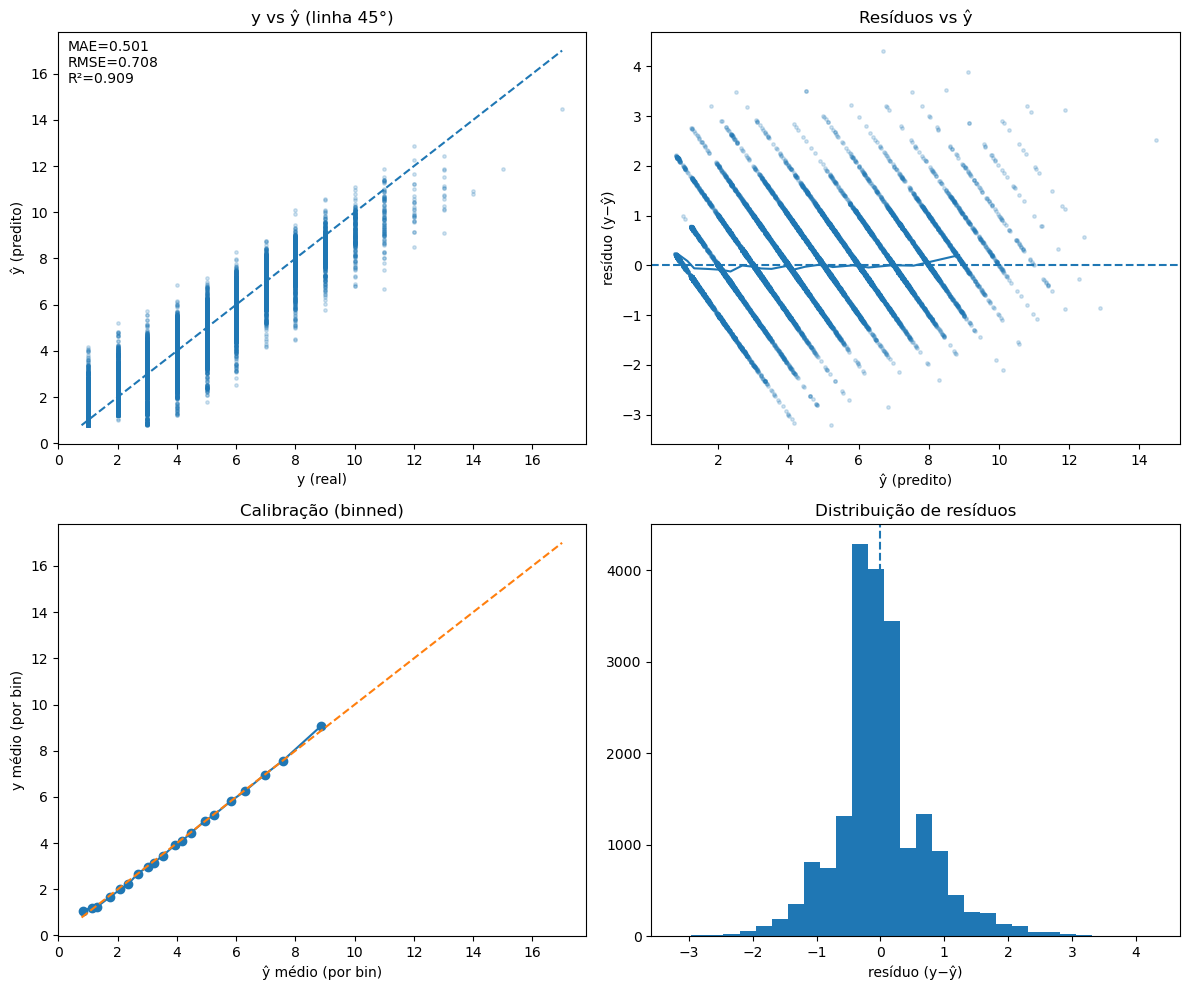

In [37]:
y_pred = regressor.predict(X_test)
regression_diagnostics(y_test, y_pred, bins=20)